<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
!pip install torch==2.1.0
!pip install datasets
# !pip install torchaudio==0.13.1
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00

In [3]:
from miniai.activations import *
from miniai.learner import *
from miniai.datasets import *
from miniai.augment import *

from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor

import torch
import math

from torch import nn
from torch.nn import functional as F
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc
import matplotlib.pyplot as plt
from ipdb import set_trace as st
from functools import partial
from torch import optim
from torch.optim import lr_scheduler
import wandb

from torchvision import transforms
from torchvision.transforms import v2

wandb.login()

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
dsd = load_dataset('fashion_mnist')
set_seed(42)

def new(some_data):
  def transform(some_data):
    some_data['image'] = [to_tensor(i) for i in some_data['image']]
  transform(some_data)

  return some_data

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  xs = torch.stack(xs)
  xs = (xs - xs.mean())/xs.std()
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(new)
dls = DataLoaders.from_dd(tds, 512, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
def norm_input(d):
  return ((d[0] - d[0].mean())/d[0].std(), d[1])

class NormTransformCB(Callback):
  def __init__(self, tfm = norm_input): self.tfm = tfm
  def before_batch(self, learn):
    self.learn = learn
    self.learn.batch = self.tfm(self.learn.batch)

class LayerNorm(nn.Module):
  def __init__(self, eps = 1e-05):
    super().__init__()
    fc.store_attr()
    self.mult = nn.Parameter(torch.tensor(1.))
    self.add = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    mean, var = x.mean((1, 2, 3), keepdim = True), x.var((1, 2, 3), keepdim = True)
    x = (x - mean)/(var + self.eps).sqrt()
    return self.mult*x + self.add

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

def init_weights(m):
  if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight)

class GeneralRelu(nn.Module):
  def __init__(self, leak = None, sub = None, max_v = None):
    super().__init__()
    fc.store_attr()

  def forward(self, x):
    x = F.relu(x) if not self.leak else F.leaky_relu(x, negative_slope = self.leak)
    if self.sub: x.sub_(self.sub)
    if self.max_v: x.clamp_max_(self.max_v)
    return x

def plot_func(model):
  # st()
  with torch.no_grad():
    x = torch.linspace(-10, 10, 200)
    y = model(x)
  plt.plot(x, y)
  plt.grid(True)
  plt.axhline(y = 0, color = 'k')
  plt.axvline(x = 0, color = 'k')
  plt.show()
  # print(x, y)

def conv(ni, nf, stride = 2, ks = 3, act = nn.ReLU):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2)]
  if act: layers.append(act())
  return nn.Sequential(*layers)

def get_model(act = nn.ReLU, nfs = [1, 8, 16, 32, 64], nc = 10):
  layers = [conv(nfs[i], nfs[i+1], act = act) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None), nn.Flatten())

def init_weights(m, leaky = 0., init_function = nn.init.kaiming_normal_):
  if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d, nn.Linear)): init_function(m.weight, a = leaky)

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if norm: layers.append(norm() if norm == LayerNorm else norm(nf)) # else its a batch norm.
  if act: layers.append(act())
  return nn.Sequential(*layers)

def conv(nin, nout, stride = 2, ks = 3, relu = True):
  layers = [nn.Conv2d(nin, nout, stride = stride, kernel_size = ks, padding = ks//2)]
  if relu: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

def gl():
  return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, relu=False),  #1x1
        nn.Flatten()]

def gm(layers = None):
  if not layers: layers = gl()
  return nn.Sequential(*layers)

def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if act: layers.append(act())
  if norm: layers.append(norm(nf) if norm.__name__ in ("BatchNorm2d", "BatchNorm1d", "BatchNorm3d") else norm()) # else its a batch norm.
  return nn.Sequential(*layers)

def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64], nc = 10, norm = None, bias = True):
  layers = [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None, norm = None), nn.Flatten())

def get_callbacks(stats_layer = GeneralRelu):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB(accuracy=MulticlassAccuracy())
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class EpochSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class): super().__init__(sched_class)
  def after_epoch(self,learn): self.step(learn)

class RecorderCB(Callback):

  def __init__(self, **hp):
    self.hp = hp

  def before_fit(self, learn):
    self.pg = learn.opt.param_groups
    self.hp_store = {k: [] for k in self.hp.keys()}

  def after_batch(self, learn):
    if not learn.training: return
    for k, v in self.hp.items(): self.hp_store[k].append(v(self.pg))

  def plot(self, *args, **kwargs):
    for k, v in self.hp_store.items():
      plt.plot(v, label = k)
      plt.legend()
      plt.show()

def _lr(pg): return pg[0]['lr']

def _mom(pg): return pg[0]['betas'][0]

def _rms_prop(pg): return pg[0]['betas'][1]

def _wd(pg): return pg[0]['weight_decay']

def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

In [6]:
class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [ResBlock(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

def get_model_v2(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [ResBlock(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class SimpleResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    # self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.convs[-1][-1].weight, 0.)

  def play(self, x):
    return  self.convs(x)

  def forward(self, x):
    return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'SimpleResBlock'

def get_model_v3(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

class OneCycleLRS(LRScheduler):
  def __init__(self, opt, total_steps = None, num_epochs = None, steps_per_epoch = None, lr_min = None, lr_max = None, b_min = None, b_max = None, tip_off = 0.2):
    super().__init__()
    self.opt = opt
    self.tip_off = tip_off
    self.total_steps = self.calculate_steps(total_steps, num_epochs, steps_per_epoch)
    self.lr_range = self.get_lr_range(lr_min, lr_max)
    self.beta_range = self.get_beta_range(b_min, b_max)
    self.setup()

  def calculate_steps(self, total_steps, num_epochs, steps_per_epoch):
    if total_steps: return total_steps
    elif steps_per_epoch and num_epochs: return steps_per_epoch*num_epochs
    else: raise ValueError("Couldn't determine total number of steps")

  def get_lr_range(self, lr_min, lr_max):
    if not lr_min: lr_min = 1e-07
    if not lr_max: lr_max = self.opt.param_groups[0]['lr']
    return lr_min, lr_max

  def get_beta_range(self, b_min, b_max):
    if not b_min: b_min = self.opt.param_groups[0]['betas'][0]
    if not b_max: b_max = 0.96 if b_min <= self.opt.param_groups[0]['betas'][0] else 0.99
    return b_min, b_max

  def setup(self):
    # step - 1 - create the first part of it - increase
    p1_step_count = int(self.total_steps*self.tip_off)
    p1_dist = (torch.cos(torch.linspace(math.pi, 2*math.pi, steps = p1_step_count)) + 1)/2

    # step - 2 - create the next part of it - decrease
    p2_step_count = self.total_steps - p1_step_count
    p2_dist = (torch.cos(torch.linspace(0, math.pi, steps = p2_step_count)) + 1)/2

    self.dist = iter(torch.cat((p1_dist, p2_dist), dim = 0))
    self.opt.param_groups[0]['lr'] = self.lr_range[0]
    self.opt.param_groups[0]['betas'] = (self.beta_range[1], self.opt.param_groups[0]['betas'][1])

  def step(self):
    lr_coef = float(next(self.dist))
    beta_coef = 1 - lr_coef
    self.opt.param_groups[0]['lr'] = self.lr_range[0] + (self.lr_range[1] - self.lr_range[0])*lr_coef
    self.opt.param_groups[0]['betas'] = ((self.beta_range[0] + (self.beta_range[1] - self.beta_range[0])*beta_coef), self.opt.param_groups[0]['betas'][1])
    self.batch_count += 1

class Dropout(nn.Module):
  def __init__(self, p = 0.2):
    super().__init__()
    self.p = p

  def forward(self, x):
    if not self.training: return x
    mask = torch.bernoulli(torch.full(x.shape, (1 - self.p))).to(x.device)
    return x*mask*(1/(1 - self.p))

class Dropout2d(Dropout):

  def forward(self, x):

    if not self.training: return x
    dist = torch.bernoulli(torch.full(x.shape[1:-2], (1 - self.p))).to(x.device)
    scaling_factor = float(dist.sum()/x.shape[1])
    out = dist[None, :, None, None] * x
    return out*(1/scaling_factor)

class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.5, p = 1.0), v2.RandomRotation(degrees=(0, 360))], p=0.8):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p = p)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

class ResBlockD(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act, p = 0.1):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = Dropout(p)

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act, p = 0.1, dropout_func = fc.noop):

    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

def get_model_v6(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) if i <= len(nfs)//2 else ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

class WandBCB(Callback):
  def __init__(self, epochs, metrics = {}, hparams = {}, name = 'Test Run'):
    fc.store_attr()
    run = wandb.init(
        project = name,
        config={
            "epochs": epochs,
        }
    )

  def after_batch(self, learn):
    (x, y), yhat = to_cpu(learn.batch), to_cpu(learn.preds)
    for k, v in self.metrics.items(): v.update(yhat, y)
    log = {k: v.compute() for k, v in self.metrics.items()}
    for k, v in self.hparams.items(): log[k] = v(learn.opt.param_groups)
    log['loss'] = learn.loss.item()
    # print(log)
    wandb.log(log)


# Activations, Parameter Initialization, Normalization(BN, LN)

In [ ]:
model = gm()
learner = MomentumLearner(model, dls, loss_func = nn.CrossEntropyLoss(), cbs = cbs, lr = 0.3, mom = 0.9)

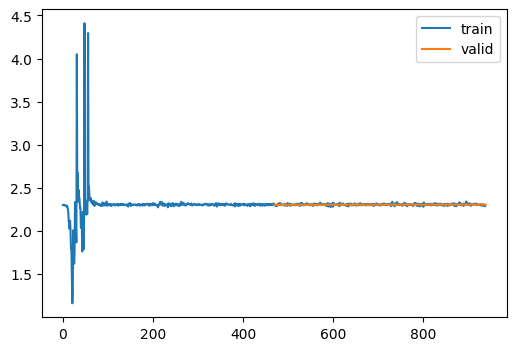

In [ ]:
learner.fit(2)

In [ ]:
def fit(model, epochs=1, xtra_cbs=None, lr = 0.6):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=lr, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn


In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

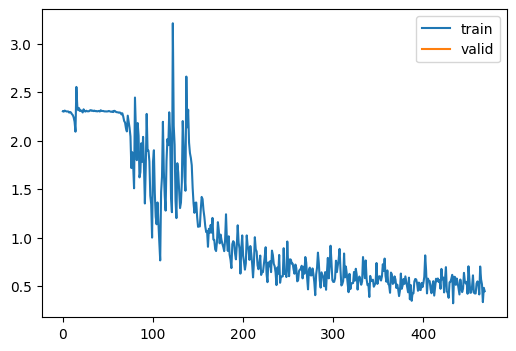

In [ ]:
set_seed(1)
model = nn.Sequential(*gl())
fit(model, epochs = 1, xtra_cbs=[astats], lr = 0.7);

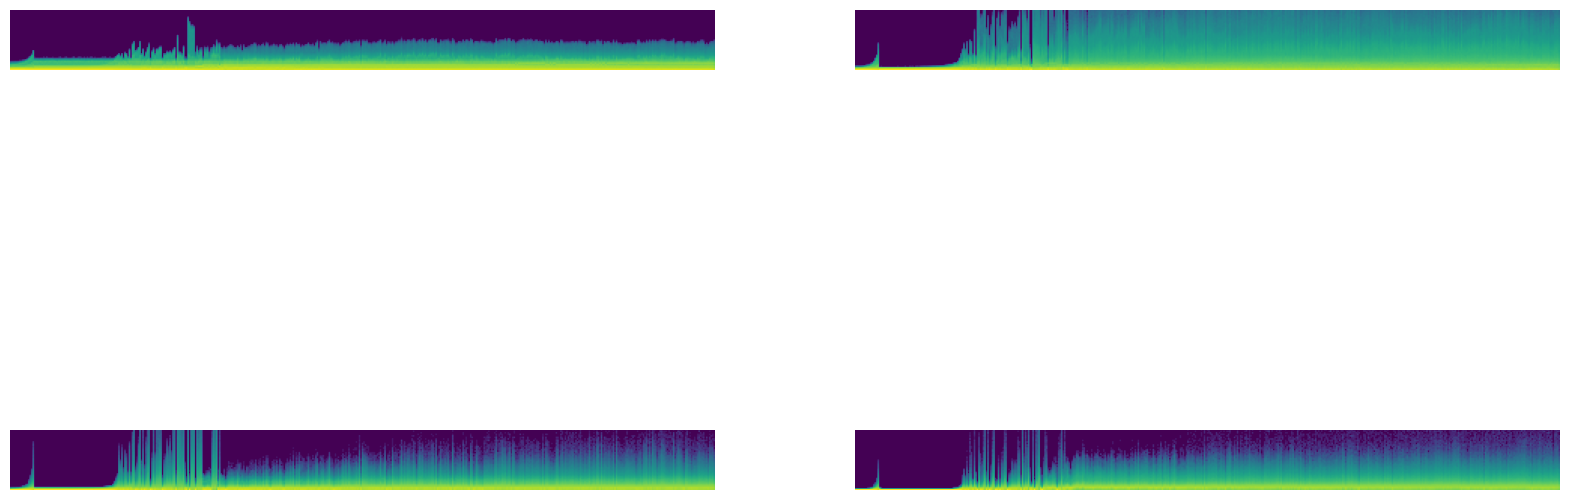

In [ ]:
astats.color_dim(figsize = (20, 10))

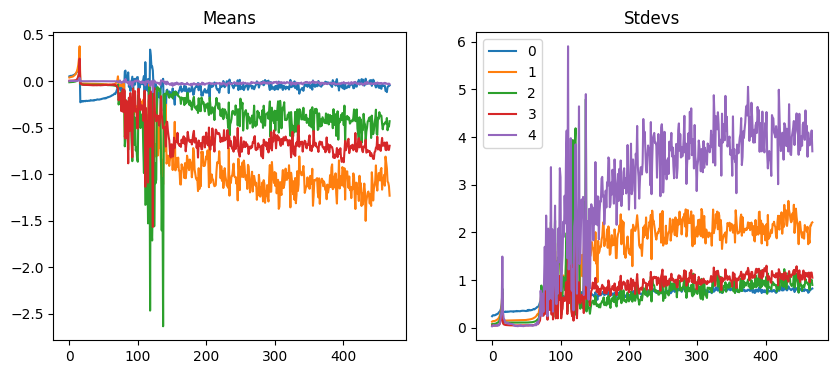

In [ ]:
astats.plot_stats()

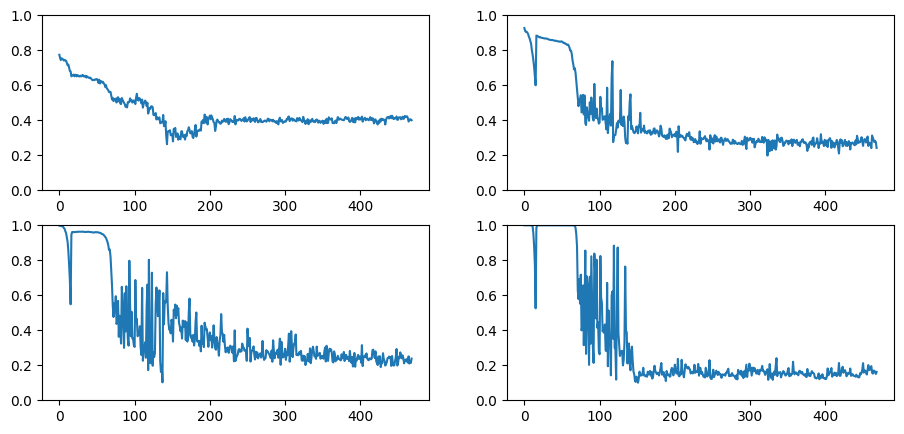

In [ ]:
astats.dead_chart()

In [ ]:
x = torch.randn(64, 10)
# x = (x - x.mean())/x.std()
for i in range(20): x = F.relu(x @ torch.randn(10, 10)*0.5)
x[:5], x[:5].mean(), x[:5].std()

(tensor([[1.7138, 0.3420, 0.0000, 1.1502, 0.0000, 0.0000, 1.3665, 0.0000, 0.0000,
          0.0000],
         [1.1181, 0.1895, 0.0000, 0.5705, 0.0000, 0.0000, 0.5529, 0.0000, 0.0000,
          0.0000],
         [0.6199, 0.1136, 0.0000, 0.3622, 0.0000, 0.0000, 0.3928, 0.0000, 0.0000,
          0.0000],
         [0.7601, 0.1660, 0.0000, 0.6016, 0.0000, 0.0000, 0.7754, 0.0000, 0.0000,
          0.0000],
         [1.6917, 0.3628, 0.0000, 1.3423, 0.0000, 0.0000, 1.7250, 0.0000, 0.0000,
          0.0000]]),
 tensor(0.3183),
 tensor(0.5174))

In [ ]:
import math; math.sqrt(2/10)

0.4472135954999579

In [ ]:
t = torch.randn(10)

In [ ]:
m = t.mean()
m, t.std()

(tensor(-0.1002), tensor(0.6067))

In [ ]:
(t-m).abs().mean()

tensor(0.4988)

In [ ]:
t

tensor([-0.1645,  0.5711, -0.4069, -0.4752,  0.6732, -1.1665,  0.4309,  0.2207,
        -0.7819,  0.0968])

In [ ]:
 t-m

tensor([-0.0643,  0.6714, -0.3067, -0.3750,  0.7734, -1.0663,  0.5311,  0.3210,
        -0.6817,  0.1971])

In [ ]:
u = torch.rand_like(t)*0.5 + m

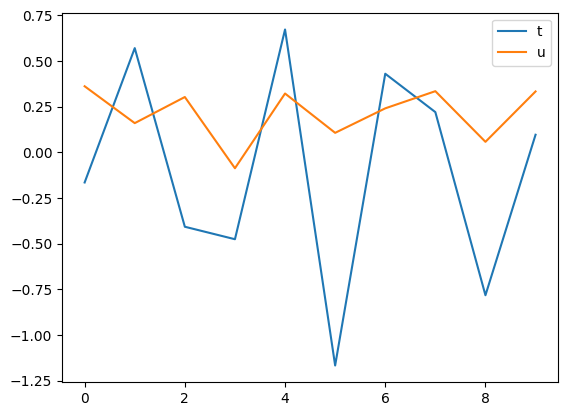

In [ ]:
import matplotlib.pyplot as plt
plt.plot(t)
plt.plot(u)
plt.legend(('t', 'u'))

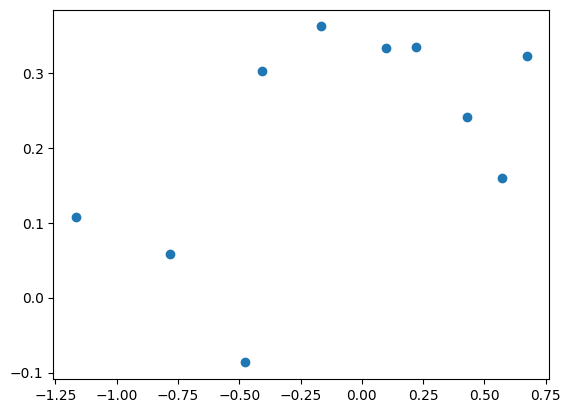

In [ ]:
plt.scatter(t, u)

In [ ]:
p = ((t - t.mean())*(t - t.mean())).mean()

In [ ]:
p, t.mean()

(tensor(0.3313), tensor(-0.1002))

In [ ]:
p*t.std() - t.mean().abs()

tensor(0.1008)

In [ ]:
model = gm()

In [ ]:
model.apply(lambda m: print(type(m).__name__))

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Sequential
Flatten
Sequential


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
x = torch.randn(200, 200)
print(x.mean(), x.std())
nn.init.kaiming_normal_(x)
x.mean(), x.std()

tensor(0.0011) tensor(1.0021)


(tensor(9.7181e-05), tensor(0.0997))

In [ ]:
def init_weights(m):
  if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight)

In [ ]:
model = gm()
model = model.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [ ]:
set_seed(42)

In [ ]:
learner = MomentumLearner(gm().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

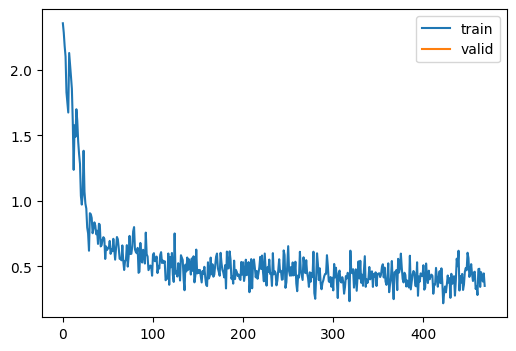

In [ ]:
learner.fit(1)

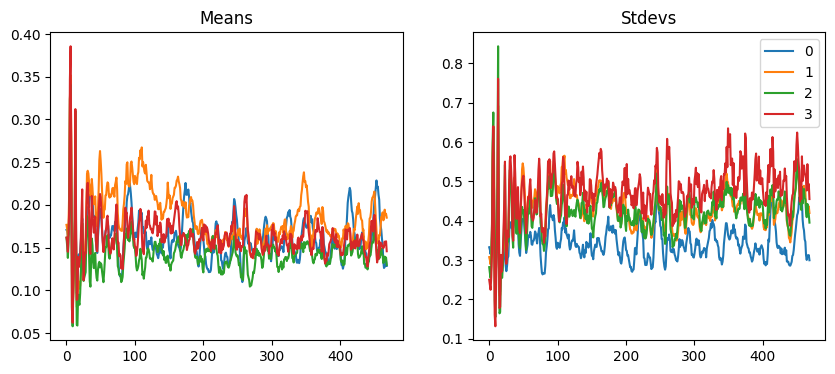

In [ ]:
astats.plot_stats()

In [ ]:
x, y = next(iter(dls.train))

In [ ]:
x.mean(), x.std()

(tensor(0.2828), tensor(0.3565))

In [ ]:
def norm_input(d):
  return ((d[0] - d[0].mean())/d[0].std(), d[1])

class NormTransformCB(Callback):
  def __init__(self, tfm): self.tfm = tfm
  def before_batch(self, learn):
    self.learn = learn
    self.learn.batch = self.tfm(self.learn.batch)

In [ ]:
norm_cb = NormTransformCB(norm_input)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
norm_cb = NormTransformCB(norm_input)
cbs = [norm_cb, DeviceCB(), metrics, ProgressCB(plot=True), astats]

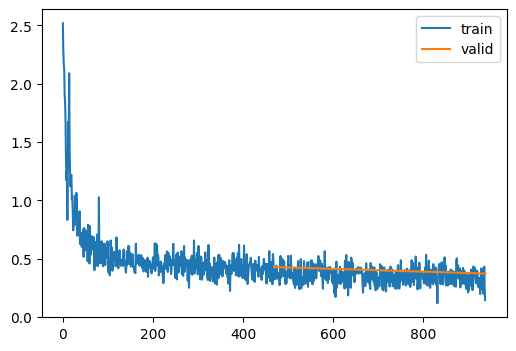

In [ ]:
learner = MomentumLearner(gm().apply(init_weights), dls, F.cross_entropy, lr=0.05, cbs=cbs, mom = 0.9)
learner.fit(2)

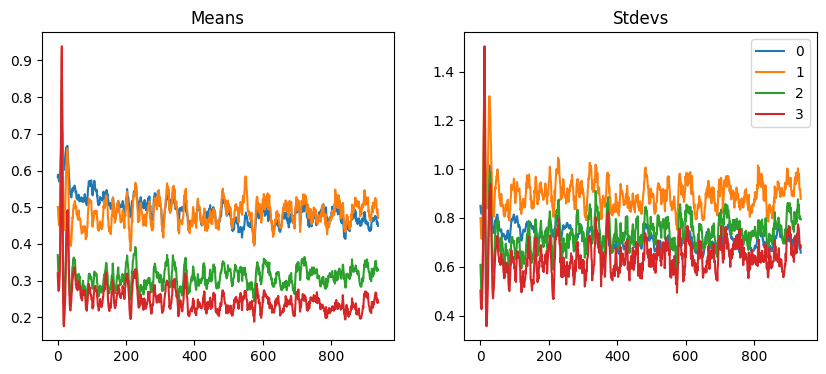

In [ ]:
astats.plot_stats()

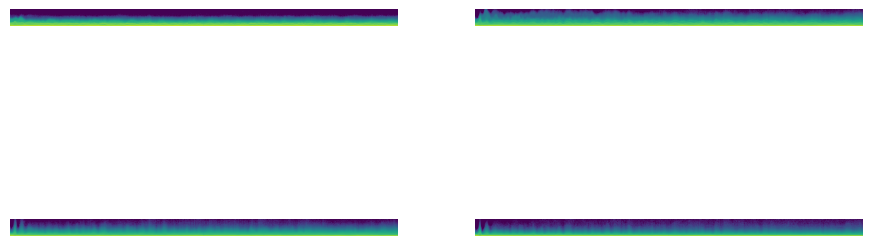

In [ ]:
astats.color_dim()

In [ ]:
from ipdb import set_trace as st

class GeneralRelu(nn.Module):
  def __init__(self, leak = None, sub = None, max_v = None):
    super().__init__()
    fc.store_attr()

  def forward(self, x):
    x = F.relu(x) if not self.leak else F.leaky_relu(x, negative_slope = self.leak)
    if self.sub: x.sub_(self.sub)
    if self.max_v: x.clamp_max_(self.max_v)
    return x

def plot_func(model):
  # st()
  with torch.no_grad():
    x = torch.linspace(-10, 10, 200)
    y = model(x)
  plt.plot(x, y)
  plt.grid(True)
  plt.axhline(y = 0, color = 'k')
  plt.axvline(x = 0, color = 'k')
  plt.show()
  # print(x, y)


In [ ]:
from ipdb import set_trace as st
def plot_func(model):
  # st()
  with torch.no_grad():
    x = torch.linspace(-10, 10, 200)
    y = model(x)
  plt.plot(x, y)
  plt.grid(True)
  plt.axhline(y = 0, color = 'k')
  plt.axvline(x = 0, color = 'k')
  plt.show()
  # print(x, y)


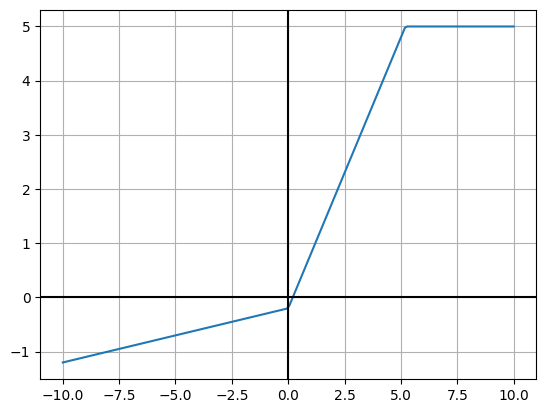

In [ ]:
plot_func(GeneralRelu(0.1, 0.4, 5))

In [ ]:
from functools import partial

def conv(ni, nf, stride = 2, ks = 3, act = nn.ReLU):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2)]
  if act: layers.append(act())
  return nn.Sequential(*layers)

def get_model(act = nn.ReLU, nfs = [1, 8, 16, 32, 64], nc = 10):
  layers = [conv(nfs[i], nfs[i+1], act = act) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None), nn.Flatten())

def init_weights(m, leaky = 0.):
  if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight, a = leaky)

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.4, max_v = None)
iw = partial(init_weights, leaky = 0.1)

In [ ]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]

In [ ]:
x, y = next(iter(dls.train))
yhat = model(x)
loss = F.cross_entropy(yhat, y)
loss.backward()

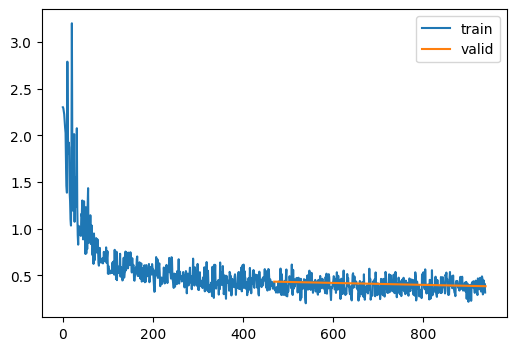

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = None, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]
model = get_model(act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.15, cbs = cbs, mom = 0.9)
learner.fit(2)

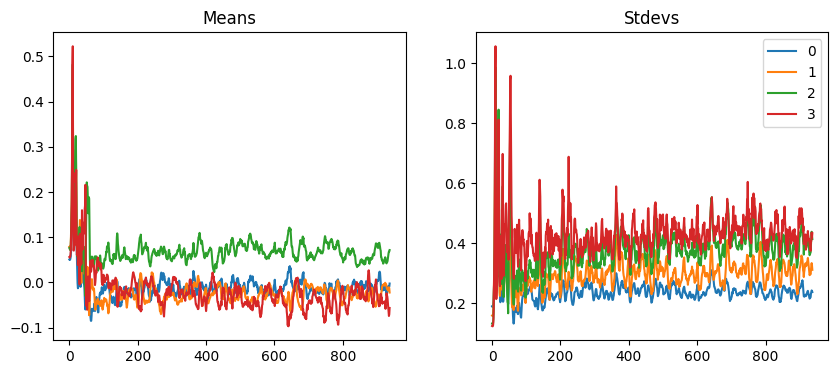

In [ ]:
astats.plot_stats()

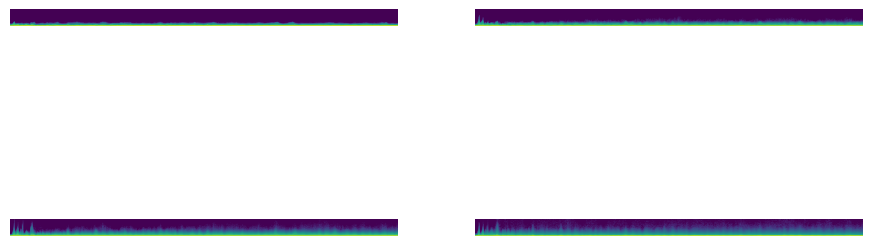

In [ ]:
astats.color_dim()

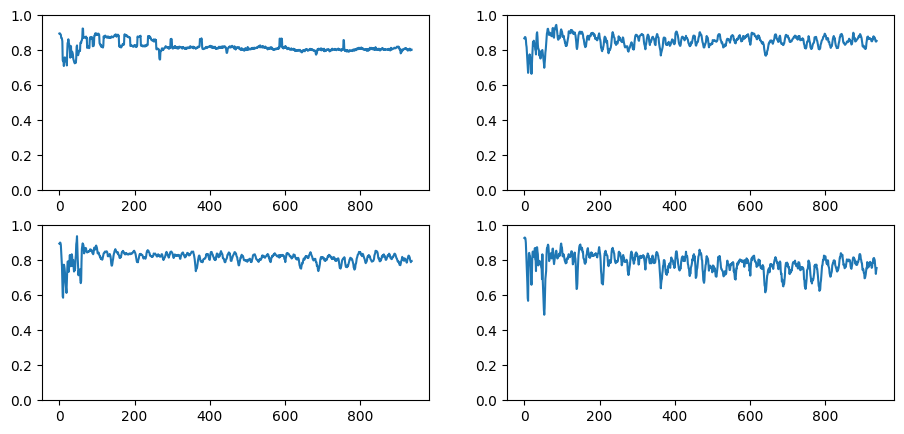

In [ ]:
astats.dead_chart()

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, eps = 1e-05):
    super().__init__()
    fc.store_attr()
    self.mult = nn.Parameter(torch.tensor(1.))
    self.add = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    # st()
    mean, var = x.mean((1, 2, 3), keepdim = True), x.var((1, 2, 3), keepdim = True)
    x = (x - mean)/(var + self.eps).sqrt()
    return self.mult*x + self.add


In [ ]:
def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if norm: layers.append(norm(nf) if isinstance(norm, [nn.BatchNorm2d, nn.BatchNorm1d, nn.BatchNorm3d]) else norm()) # else its a batch norm.
  if act: layers.append(act())
  return nn.Sequential(*layers)

def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64], nc = 10, norm = None, bias = True):
  layers = [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None, norm = None), nn.Flatten())

In [ ]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64], nc = 10, norm = None, bias = True):
  layers = [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None, norm = None), nn.Flatten())

In [ ]:
model = get_model(norm = LayerNorm, bias = True)

In [ ]:
model

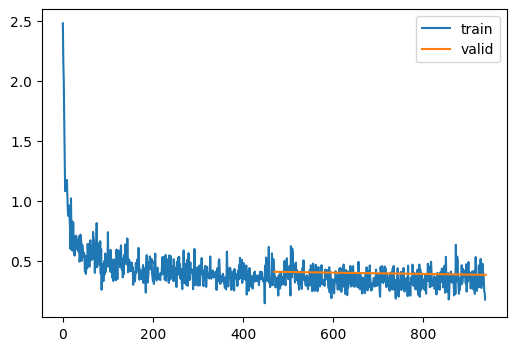

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]
model = get_model(norm = LayerNorm, bias = True, act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.15, cbs = cbs, mom = 0.9)
learner.fit(2)

In [ ]:
model[-3][1].__dict__['_parameters']

OrderedDict([('mult',
              Parameter containing:
              tensor(1.8067, requires_grad=True)),
             ('add',
              Parameter containing:
              tensor(-0.9065, requires_grad=True))])

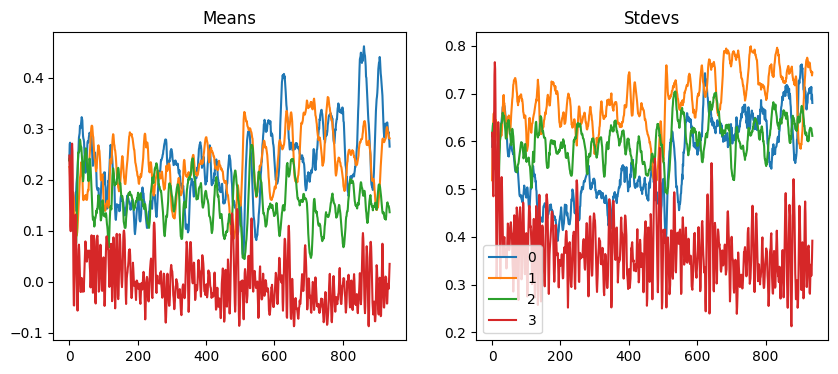

In [ ]:
astats.plot_stats()

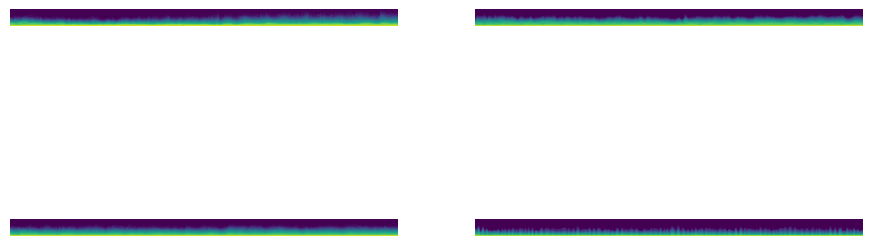

In [ ]:
astats.color_dim()

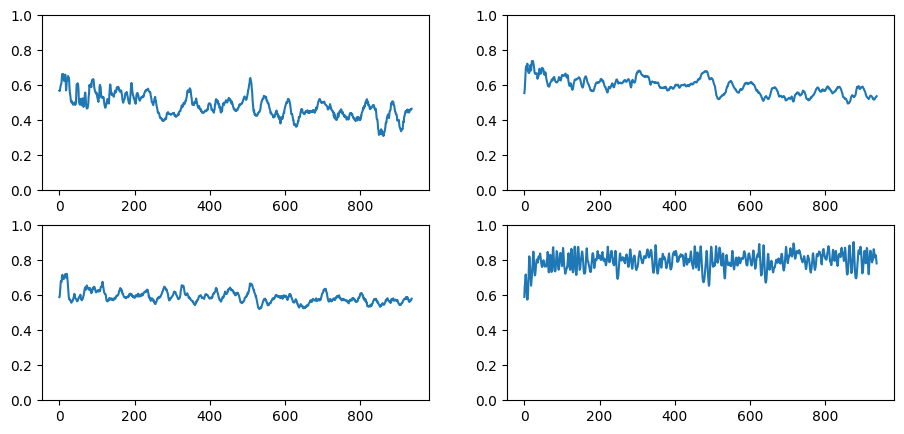

In [ ]:
astats.dead_chart()

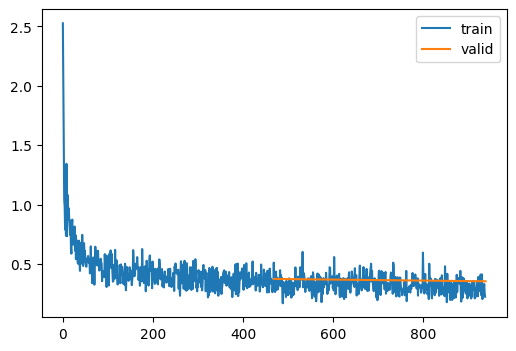

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, mom = 0.9)
learner.fit(2)

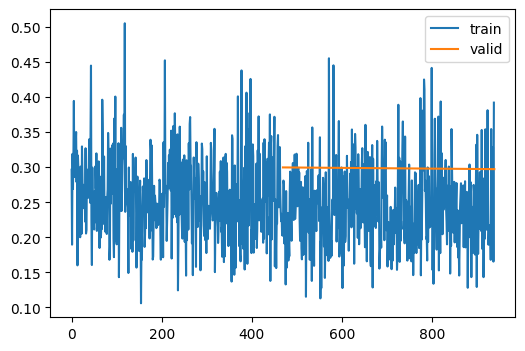

In [ ]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.05, cbs = cbs, mom = 0.9)
learner.fit(2)

# Optimization Algorithms.

In [ ]:
class SGD:

  def __init__(self, params, lr = 1e-01, wd = 0.):

    self.params = list(params)
    self.lr, self.wd, self.i = lr, wd, 0
    print(wd)

  def step(self):
    with torch.no_grad():
      for p in self.params:
        if self.wd != 0.: self.reg_step(p)
        self.opt_step(p)
      self.i += 1

  def opt_step(self, p): p.sub_(self.lr*p.grad)

  def reg_step(self, p): p.sub_(p*self.lr*self.wd)

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()



In [ ]:
def get_callbacks():
  astats = ActivationStats(fc.risinstance(GeneralRelu))
  metrics = MetricsCB(accuracy=MulticlassAccuracy())
  return [DeviceCB(), metrics, ProgressCB(plot = True), astats]

0.0


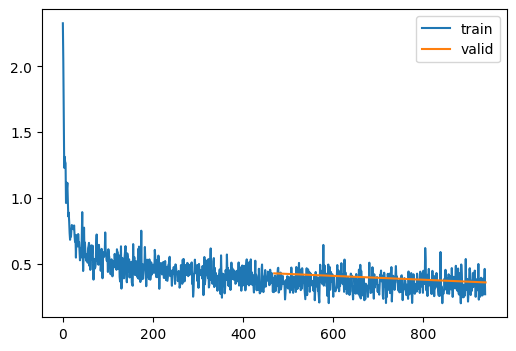

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks()
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = SGD)
learner.fit(2)

0.0


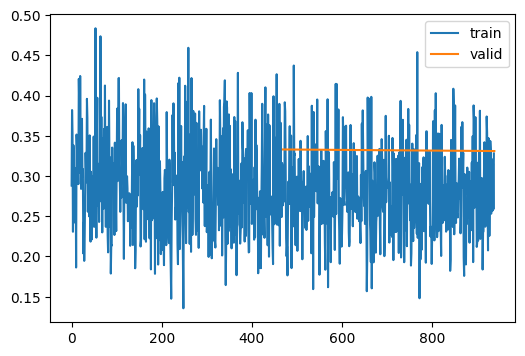

In [ ]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.04, cbs = cbs, opt_func = SGD)
learner.fit(2)

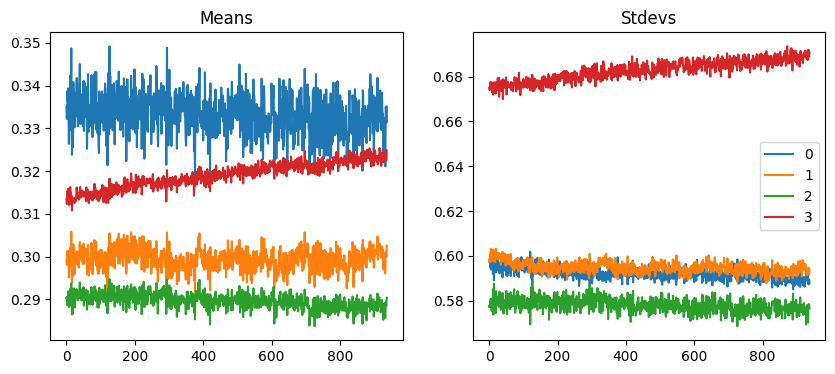

In [ ]:
cbs[-1].plot_stats()

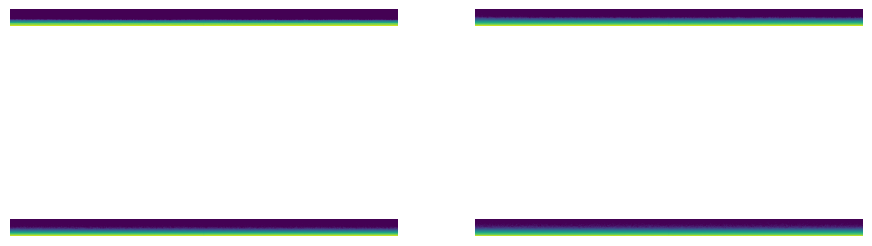

In [ ]:
cbs[-1].color_dim()

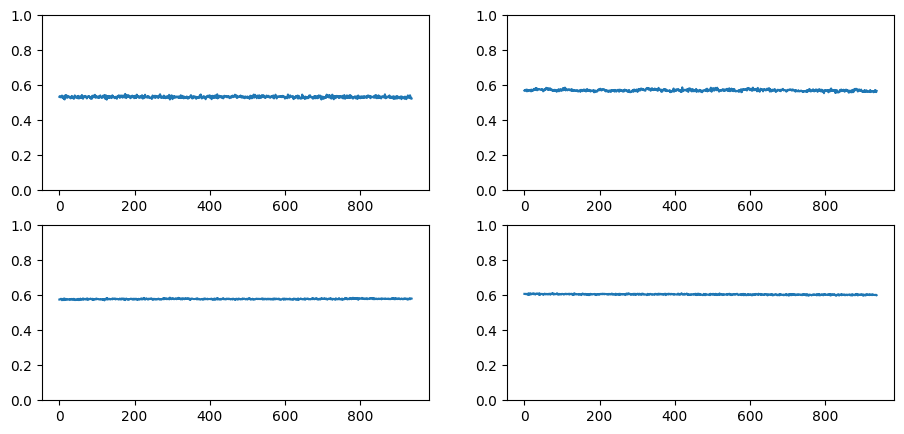

In [ ]:
cbs[-1].dead_chart()

0.0


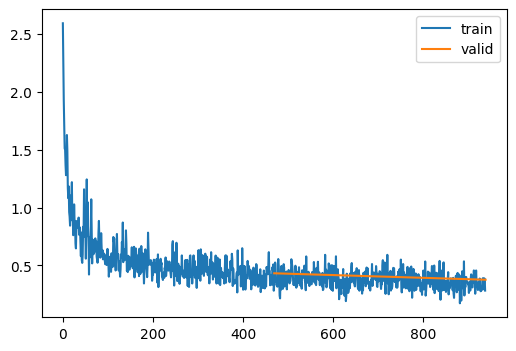

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks()
model = get_model(norm = LayerNorm, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = SGD)
learner.fit(2)

0.0


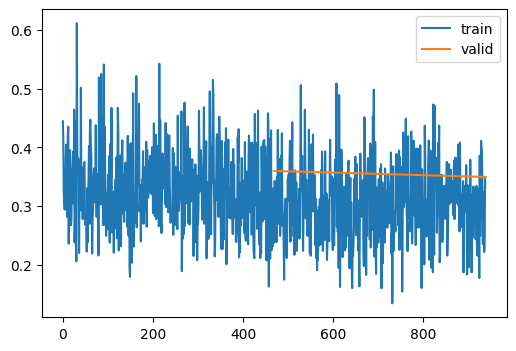

In [ ]:
learner.opt.lr = 0.05
learner.fit(2)

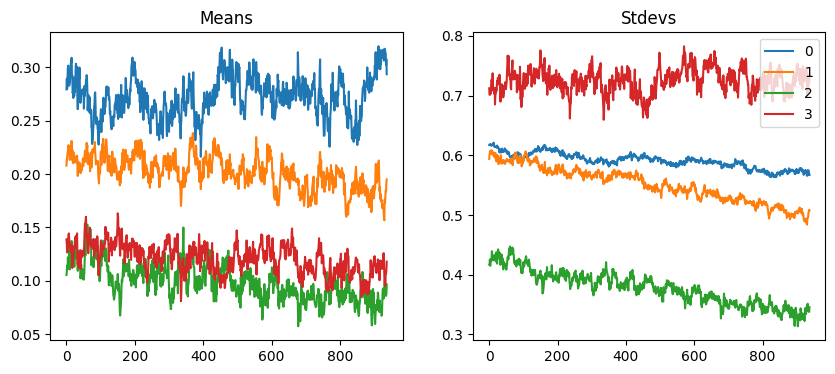

In [ ]:
cbs[-1].plot_stats()

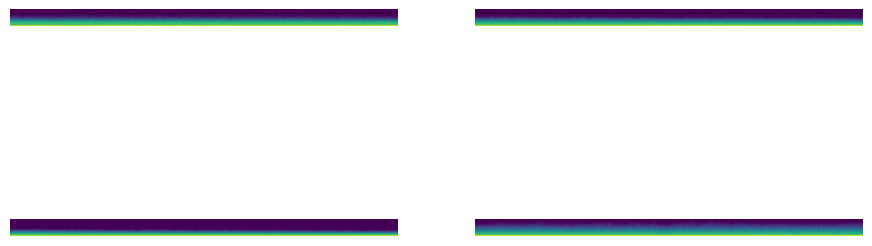

In [ ]:
cbs[-1].color_dim()

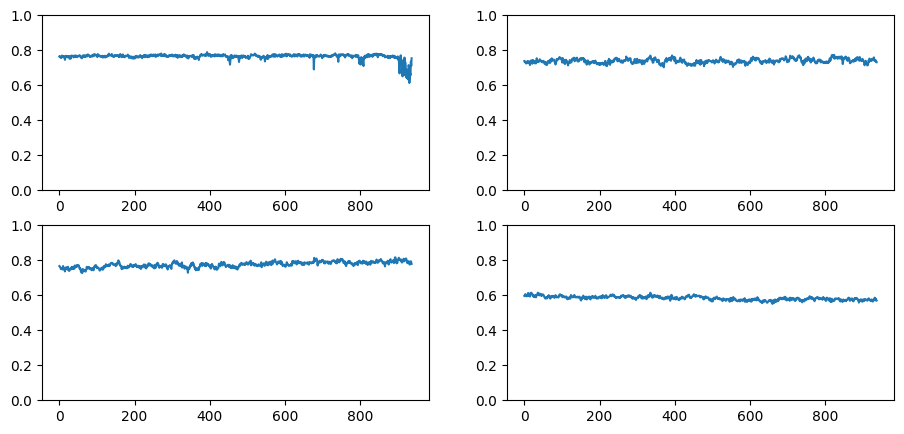

In [ ]:
cbs[-1].dead_chart()

0.01


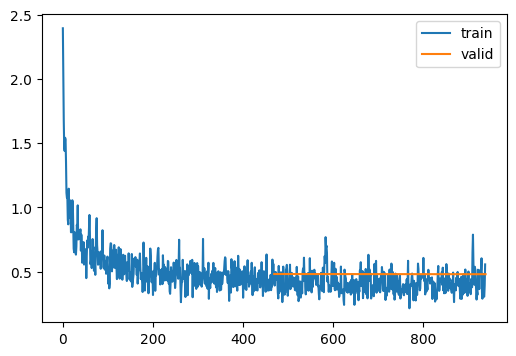

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.2, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks()
model = get_model(norm = LayerNorm, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = partial(SGD, wd = 1e-02))
learner.fit(2)

0.01


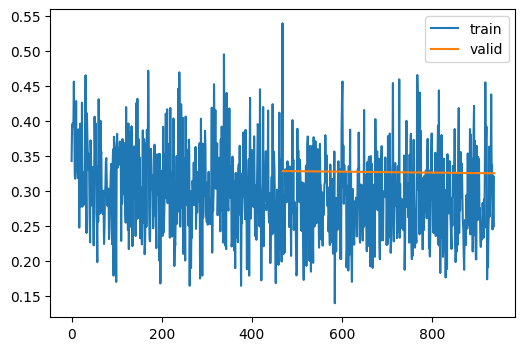

In [ ]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.04, cbs = cbs, opt_func = partial(SGD, wd = 1e-02))
learner.fit(2)

In [ ]:
class SGDMomentum(SGD):
  def __init__(self,  params, lr = 1e-01, wd = 0., mom = 0.9):
    super().__init__(params, lr, wd = wd)
    self.mom = mom

  def opt_step(self, p):
    if not hasattr(p, 'grad_avg'): p.grad_avg = p.grad
    p.grad_avg.lerp_(p.grad, (1-self.mom))
    p.sub_(self.lr*p.grad_avg)

0.01


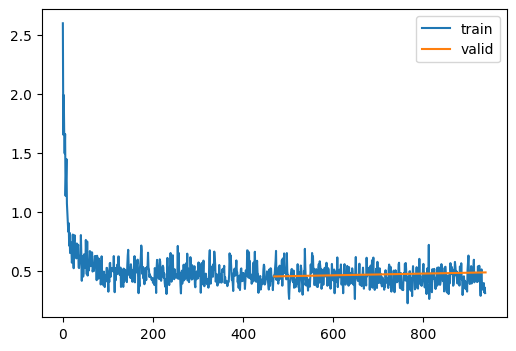

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)


cbs = get_callbacks()

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.5, cbs = cbs, opt_func = partial(SGDMomentum, wd = 1e-02))
learner.fit(2)

0.01


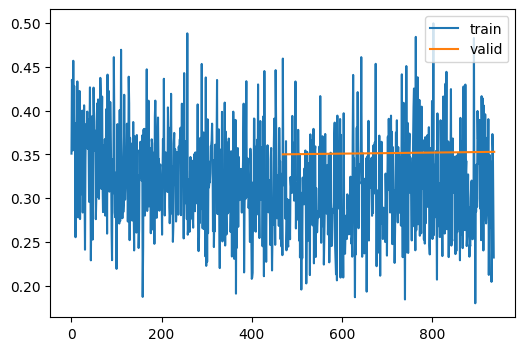

In [ ]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.05, cbs = cbs, opt_func = partial(SGDMomentum, wd = 1e-02))
learner.fit(2)

In [ ]:
class RMSProp(SGD):

  def __init__(self, params, lr = 1e-01, wd = 0., beta = 0.99, eps = 1e-05):
    super().__init__(params, lr = lr, wd = wd)
    self.beta, self.eps = beta, eps

  def one_step(self, p):
    if not hasattr(p, 'grad_avg_squared'): p.grad_avg_squared = p.grad**2
    p.grad_avg_squared.lerp_(p.grad**2, (1-self.beta))
    p.sub_(self.lr * (p.grad/torch.sqrt(p.grad_avg_squared + self.eps)))

0.0


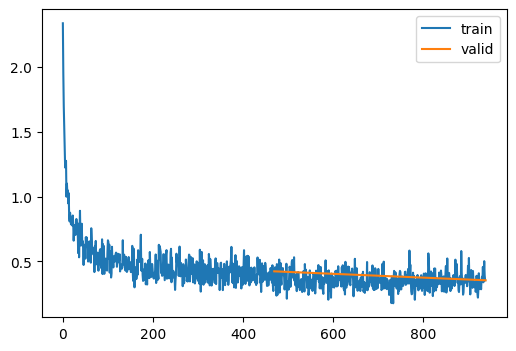

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

cbs = get_callbacks()

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = RMSProp)
learner.fit(2)

0.0


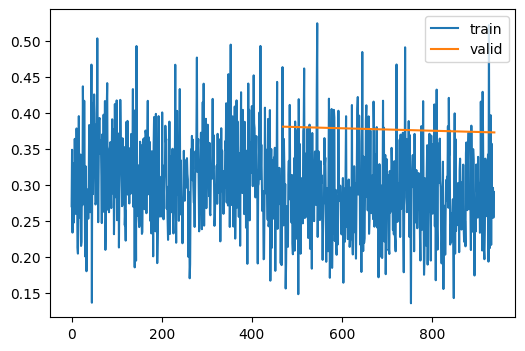

In [ ]:
learner.opt.lr = 0.05
learner.fit(2)

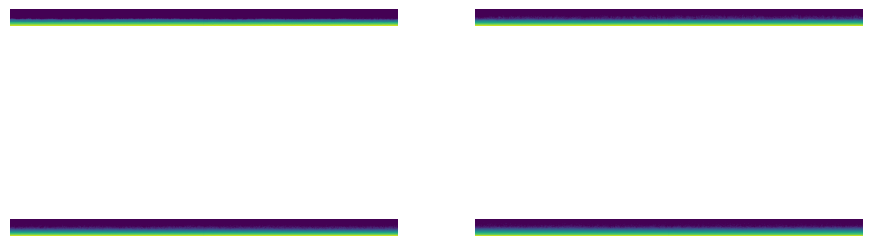

In [ ]:
cbs[-1].color_dim()

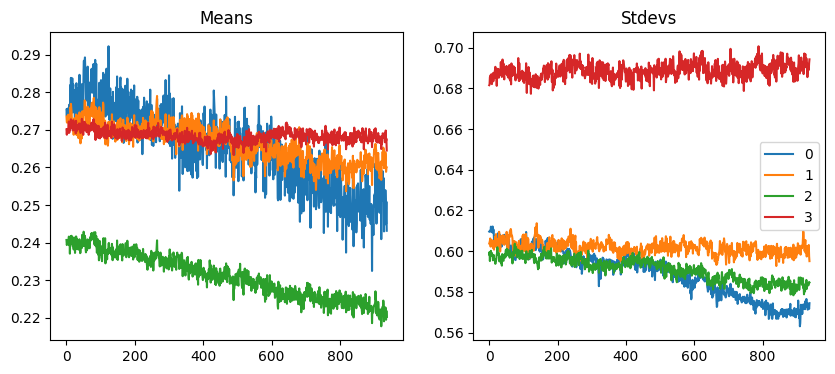

In [ ]:
cbs[-1].plot_stats()

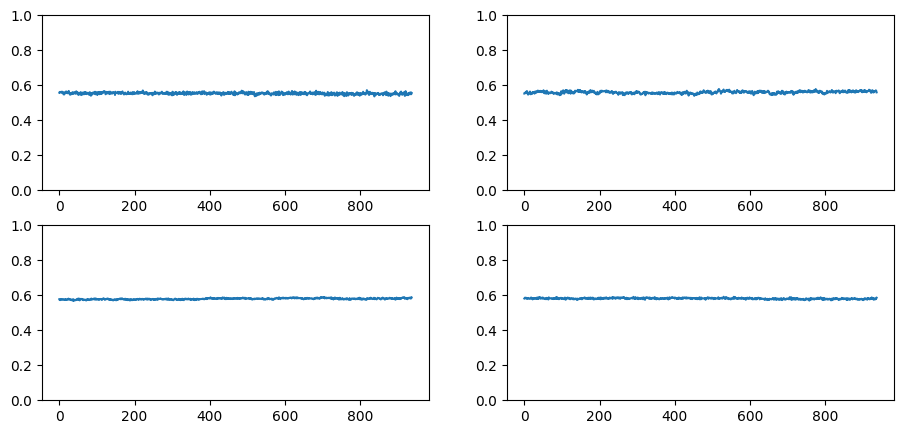

In [ ]:
cbs[-1].dead_chart()

In [ ]:
class Adam(SGD):
  def __init__(self, params, lr = 1e-01, wd = 0., betas = (0.9, 0.99), eps = 1e-05, use_mom = True, use_rms = True):
    super().__init__(params, lr = lr, wd = wd)
    self.betas, self.eps = betas, eps
    self.use_mom, self.use_rms = use_mom, use_rms

  def one_step(self, p):
    if not hasattr(p, 'grad_avg_squared'): p.grad_avg_squared = p.grad**2
    if not hasattr(p, 'grad_avg'): p.grad_avg = p.grad
    p.grad_avg_squared.lerp_(p.grad**2, (1-self.betas[1]))
    p.grad_avg.lerp_(p.grad, (1-self.betas[0]))
    update = p.grad

    if self.use_mom: update = p.grad_avg
    if self.use_rms: update = update/torch.sqrt(p.grad_avg_squared + self.eps)
    p.sub_(self.lr*update)


NameError: name 'SGD' is not defined

0.0


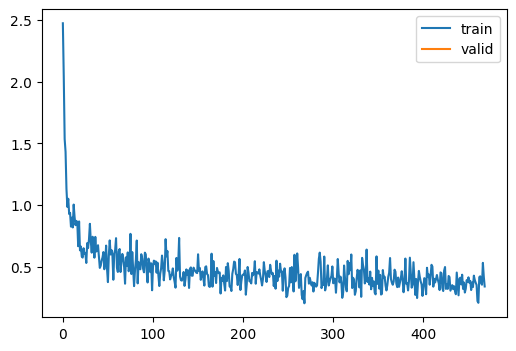

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

cbs = get_callbacks()

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.3, cbs = cbs, opt_func = Adam)
learner.fit(1)

0.0


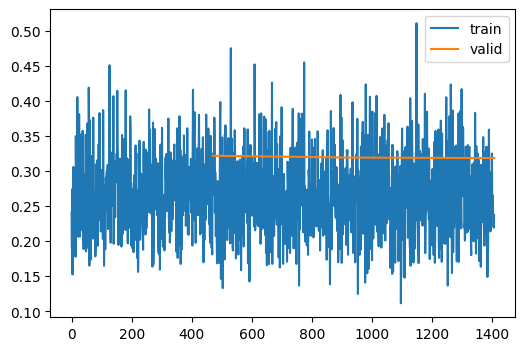

In [ ]:
learner.lr = 0.01
learner.opt.use_rms = False
learner.fit(3)

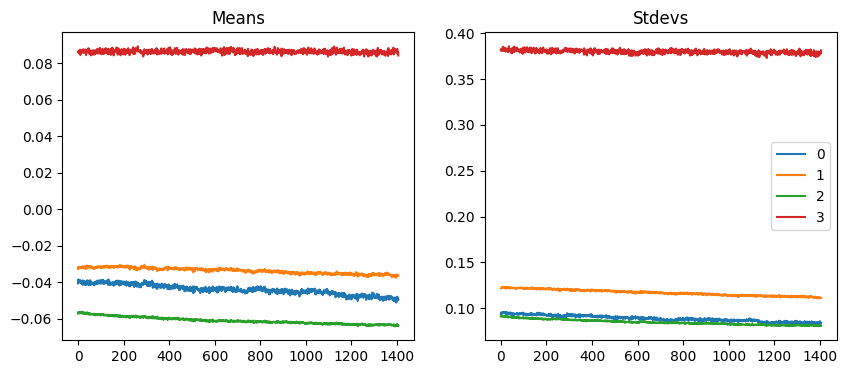

In [ ]:
 cbs[-1].plot_stats()

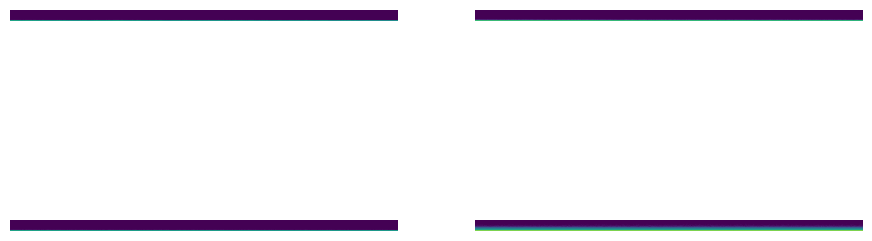

In [ ]:
cbs[-1].color_dim()

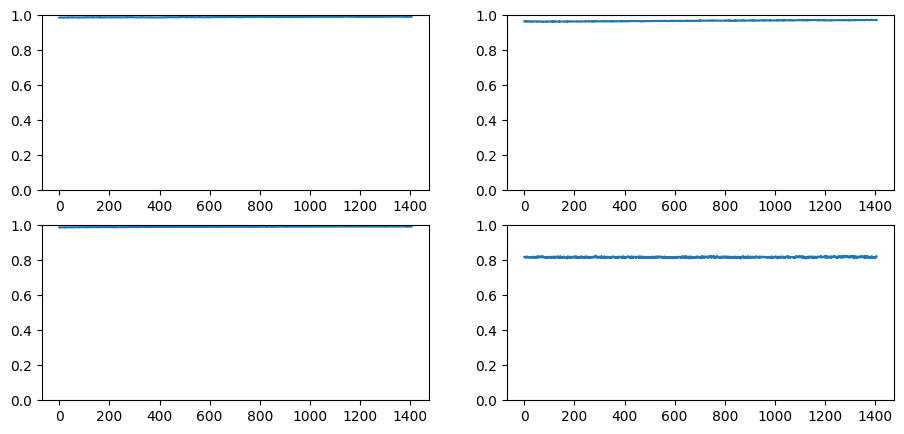

In [ ]:
cbs[-1].dead_chart()

In [ ]:
optim = torch.optim.Adam(model.parameters(), betas = (0.9, 0.99), lr = 0.1)

In [ ]:
[i for i in dir(optim) if not i.startswith('_')]

['add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [ ]:
optim.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [ ]:
optim.param_groups[0]['amsgrad']

False

In [ ]:
optim.defaults

{'lr': 0.1,
 'betas': (0.9, 0.99),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False,
 'maximize': False,
 'foreach': None,
 'capturable': False,
 'differentiable': False,
 'fused': False}

In [ ]:
optim.load_state_dict

<bound method Optimizer.load_state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.1
    maximize: False
    weight_decay: 0
)>

In [ ]:
optim.state

defaultdict(dict, {})

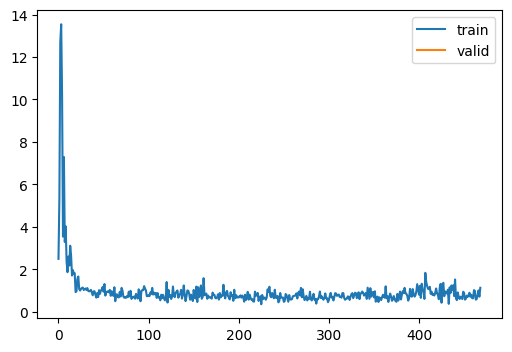

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

cbs = get_callbacks()

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.3, cbs = cbs, opt_func = torch.optim.Adam)
learner.fit(1)

In [ ]:
opt = learner.opt

In [ ]:
opt.state.keys()

In [ ]:
opt.state.values()

# Learning Rate Schedulers!

In [ ]:
lr_scheduler.__dict__['__all__']

['LambdaLR',
 'MultiplicativeLR',
 'StepLR',
 'MultiStepLR',
 'ConstantLR',
 'LinearLR',
 'ExponentialLR',
 'SequentialLR',
 'CosineAnnealingLR',
 'ChainedScheduler',
 'ReduceLROnPlateau',
 'CyclicLR',
 'CosineAnnealingWarmRestarts',
 'OneCycleLR',
 'PolynomialLR',
 'LRScheduler']

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

cbs = get_callbacks()

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.3, cbs = cbs, opt_func = torch.optim.Adam)


In [ ]:
opt = optim.AdamW(model.parameters(), lr = 0.1, weight_decay=1e-02)

In [ ]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [ ]:
sched.__dict__

{'T_max': 100,
 'eta_min': 0,
 'optimizer': AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.1
     lr: 0.0
     maximize: False
     weight_decay: 0.01
 ),
 'base_lrs': [0.1],
 'last_epoch': 300,
 'verbose': False,
 '_step_count': 301,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0]}

In [ ]:
lrs = []
# opt = optim.AdamW(model.parameters(), lr = 0.1, weight_decay=1e-02)
sched = lr_scheduler.CosineAnnealingLR(opt, 100)
for i in range(400):
  lrs.append(sched.get_lr())
  sched.step()

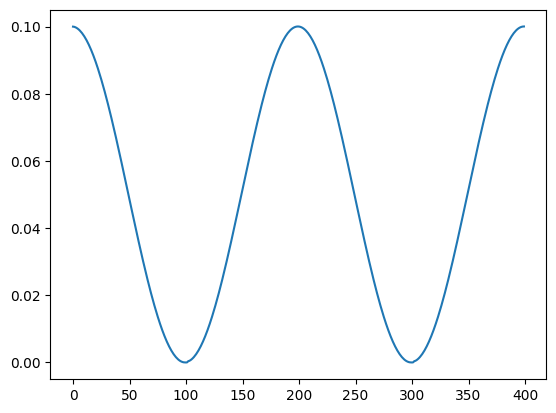

In [ ]:
plt.plot(lrs)

In [ ]:
sched = lr_scheduler.OneCycleLR(opt, max_lr = 0.1, epochs = 1, steps_per_epoch = 100)

In [ ]:
sched.__dict__

{'optimizer': AdamW (
 Parameter Group 0
     amsgrad: False
     base_momentum: 0.85
     betas: (0.95, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.004
     lr: 0.0040000000000000036
     max_lr: 0.1
     max_momentum: 0.95
     maximize: False
     min_lr: 4e-07
     weight_decay: 0.01
 ),
 'total_steps': 100,
 '_schedule_phases': [{'end_step': 29.0,
   'start_lr': 'initial_lr',
   'end_lr': 'max_lr',
   'start_momentum': 'max_momentum',
   'end_momentum': 'base_momentum'},
  {'end_step': 99,
   'start_lr': 'max_lr',
   'end_lr': 'min_lr',
   'start_momentum': 'base_momentum',
   'end_momentum': 'max_momentum'}],
 'anneal_func': <bound method OneCycleLR._annealing_cos of <torch.optim.lr_scheduler.OneCycleLR object at 0x7a7c0c1df340>>,
 'cycle_momentum': True,
 'use_beta1': True,
 'base_lrs': [0.004],
 'last_epoch': 0,
 'verbose': False,
 '_step_count': 1,
 '_get_lr_called_within_step': False,
 '_last_

In [ ]:
sched.get_lr

<bound method OneCycleLR.get_lr of <torch.optim.lr_scheduler.OneCycleLR object at 0x7a7c0c1df340>>

In [ ]:
lrs = []
moms = []
for i in range(100):
  lrs.append(sched.optimizer.param_groups[0]['lr'])
  moms.append(sched.optimizer.param_groups[0]['betas'][0])
  opt.step()
  sched.step()

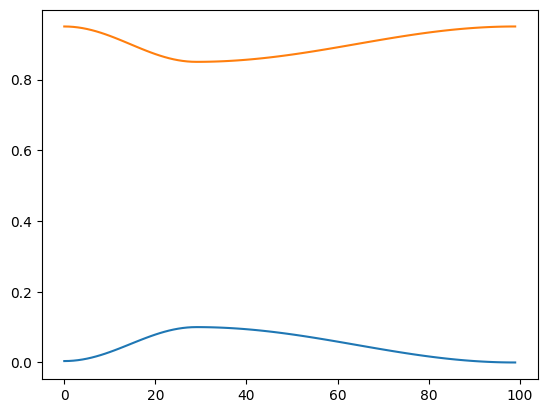

In [ ]:
plt.plot(lrs)
plt.plot(moms)

In [ ]:
class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

class EpochSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class): super().__init__(sched_class)
  def after_epoch(self,learn): self.step(learn)

class RecorderCB(Callback):

  def __init__(self, **hp):
    self.hp = hp

  def before_fit(self, learn):
    self.pg = learn.opt.param_groups
    self.hp_store = {k: [] for k in self.hp.keys()}

  def after_batch(self, learn):
    if not learn.training: return
    for k, v in self.hp.items(): self.hp_store[k].append(v(self.pg))

  def plot(self, *args, **kwargs):
    for k, v in self.hp_store.items():
      plt.plot(v, label = k)
      plt.legend()
      plt.show()

def _lr(pg): return pg[0]['lr']

def _mom(pg): return pg[0]['betas'][0]

def _rms_prop(pg): return pg[0]['betas'][1]

def _wd(pg): return pg[0]['weight_decay']

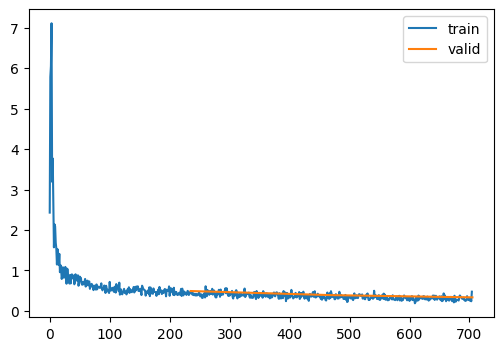

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks() + [BatchSchedulerCB(partial(lr_scheduler.CosineAnnealingLR, T_max = 3*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(3)

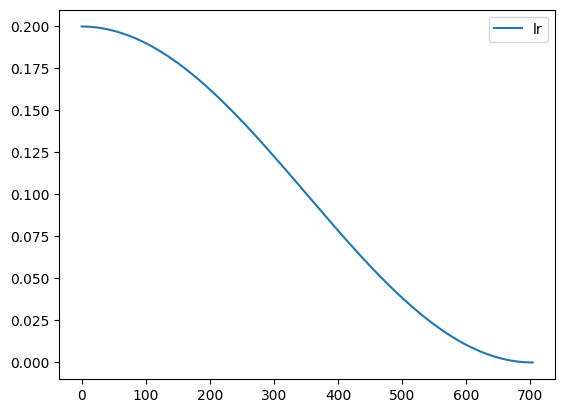

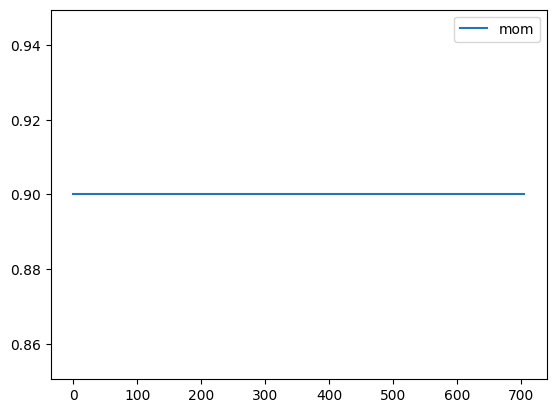

In [ ]:
cbs[-1].plot()

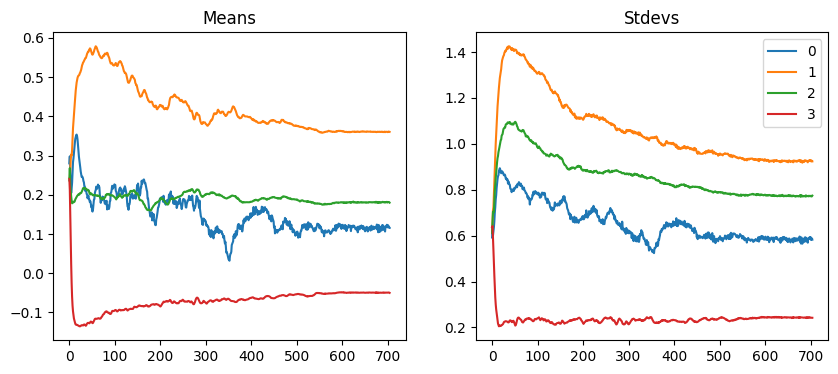

In [ ]:
cbs[-3].plot_stats()

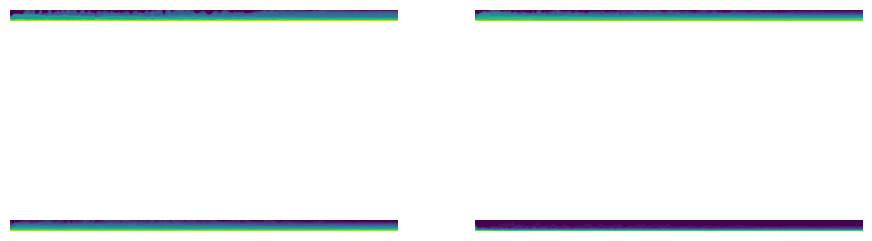

In [ ]:
cbs[-3].color_dim()

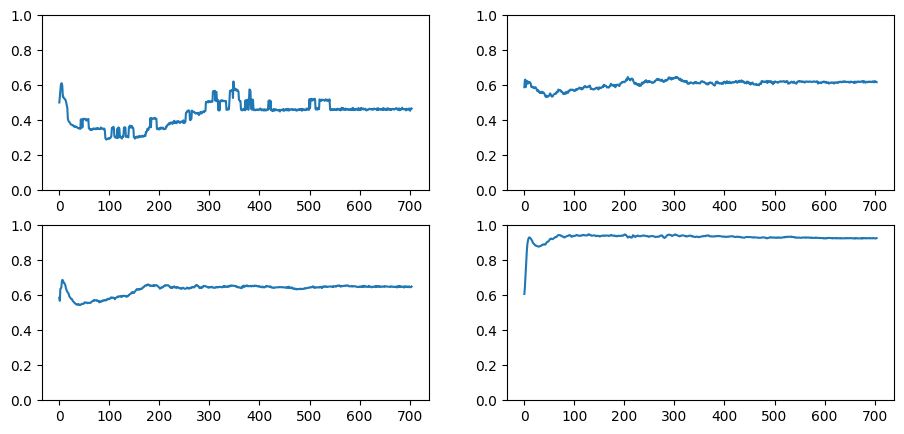

In [ ]:
cbs[-3].dead_chart()

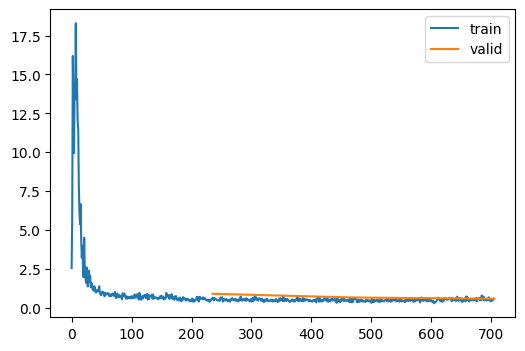

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks() + [EpochSchedulerCB(partial(lr_scheduler.CosineAnnealingLR, T_max = 3*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.25, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(3)

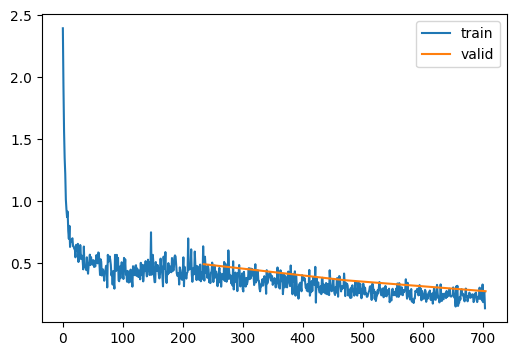

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
cbs = get_callbacks() + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = 0.1, total_steps = 3*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.1, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(3)

In [ ]:
ocbs = cbs

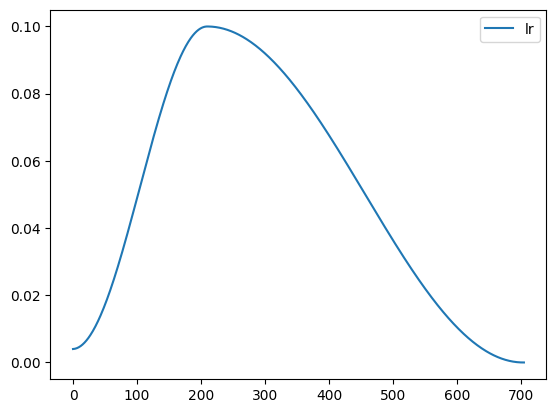

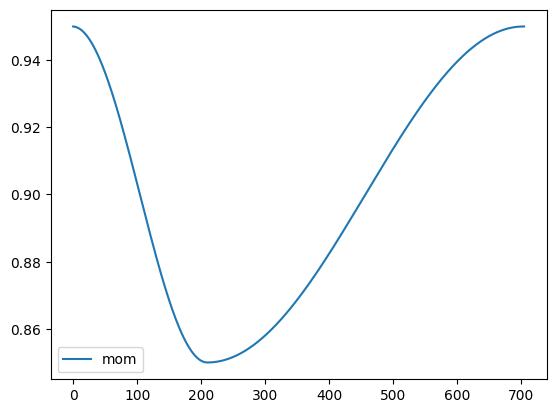

In [ ]:
ocbs[-1].plot()

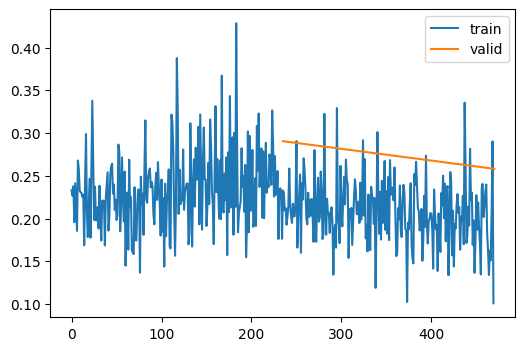

In [ ]:
cbs = get_callbacks() + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = 1e-02, total_steps = 2*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 1e-02, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(2)

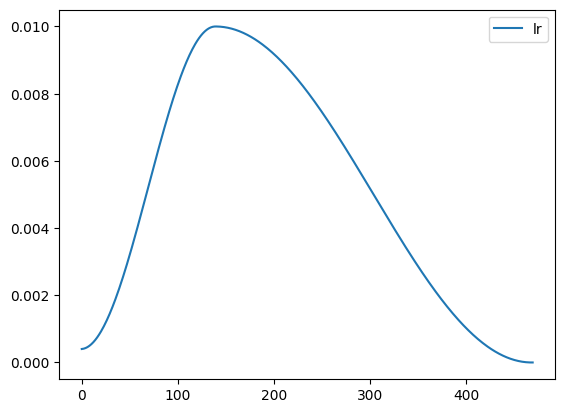

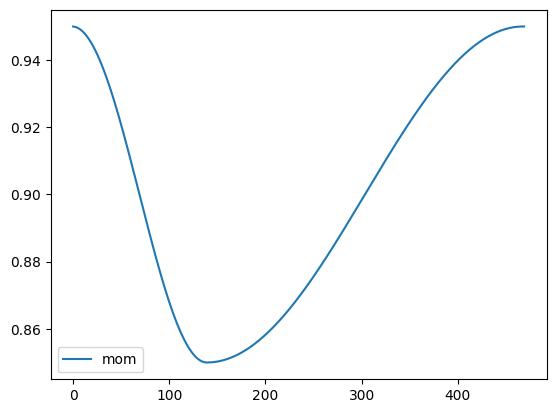

In [ ]:
cbs[-1].plot()

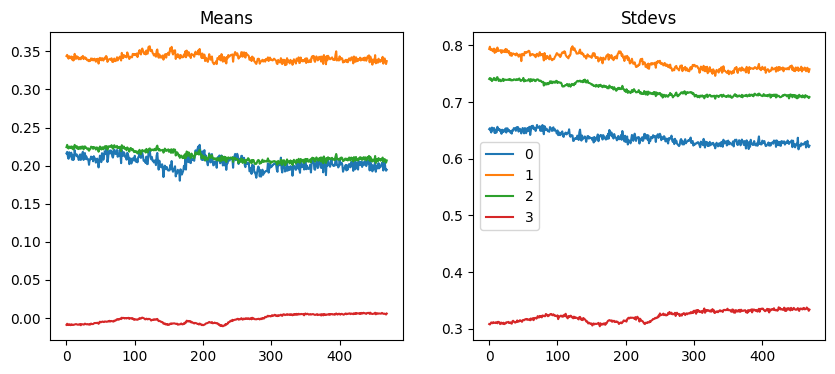

In [ ]:
cbs[-3].plot_stats()

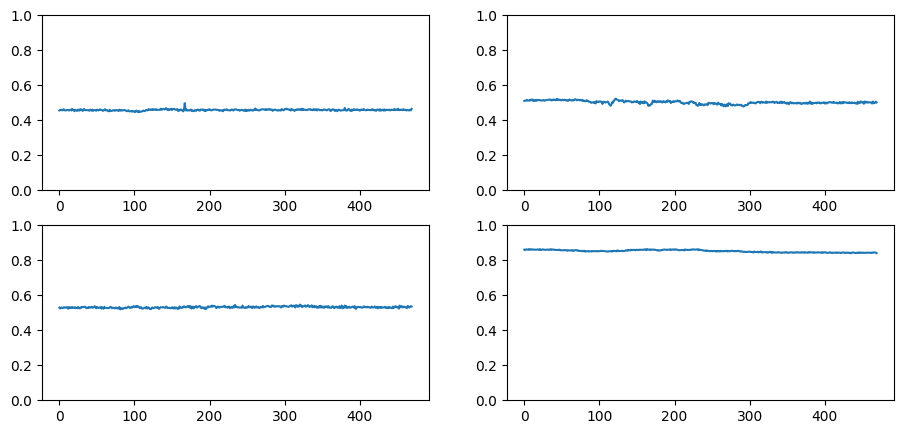

In [ ]:
cbs[-3].dead_chart()

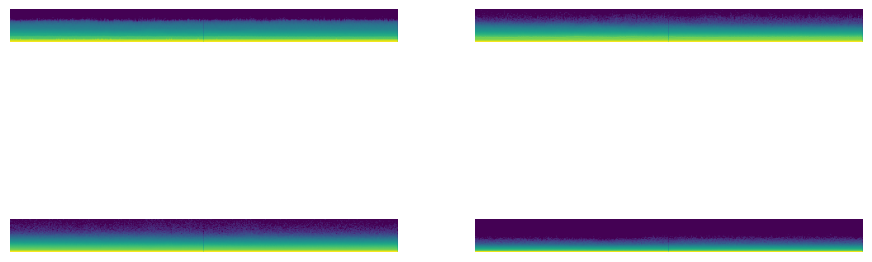

In [ ]:
cbs[-3].color_dim()

In [ ]:
params = list(model.parameters())

In [ ]:
params[0].data.numel()

72

In [ ]:
(params[0].data < 1e-04).float().sum()

tensor(34., device='cuda:0')

In [ ]:
def dead_pct(param, threshold = 1e-04):
  pct = (param.data < threshold).float().sum()/param.data.numel()
  print(f"Total Number of elements: {param.data.numel()}, number of dead_activations pct: {pct}")
  return float(pct.to('cpu').detach())


In [ ]:
dead_pcts = [dead_pct(p) for p in params]

Total Number of elements: 72, number of dead_activations pct: 0.472222238779068
Total Number of elements: 8, number of dead_activations pct: 0.0
Total Number of elements: 8, number of dead_activations pct: 0.5
Total Number of elements: 1152, number of dead_activations pct: 0.5677083134651184
Total Number of elements: 16, number of dead_activations pct: 0.0
Total Number of elements: 16, number of dead_activations pct: 0.4375
Total Number of elements: 4608, number of dead_activations pct: 0.5269097089767456
Total Number of elements: 32, number of dead_activations pct: 0.0
Total Number of elements: 32, number of dead_activations pct: 0.90625
Total Number of elements: 18432, number of dead_activations pct: 0.5331488847732544
Total Number of elements: 64, number of dead_activations pct: 0.0625
Total Number of elements: 64, number of dead_activations pct: 0.90625
Total Number of elements: 5760, number of dead_activations pct: 0.5210069417953491
Total Number of elements: 10, number of dead_ac

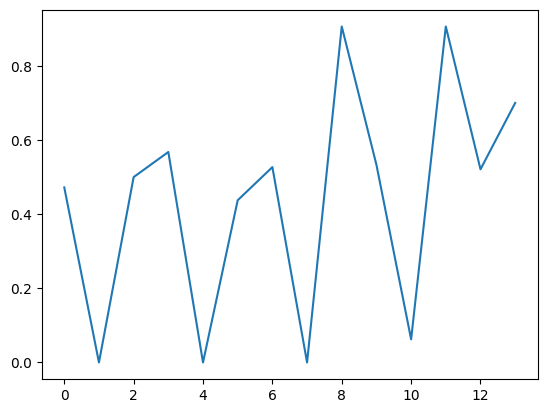

In [ ]:
dead_pcts = [dead_pct(p) for p in params]
plt.plot(dead_pcts)

## With conv relu batchnorm

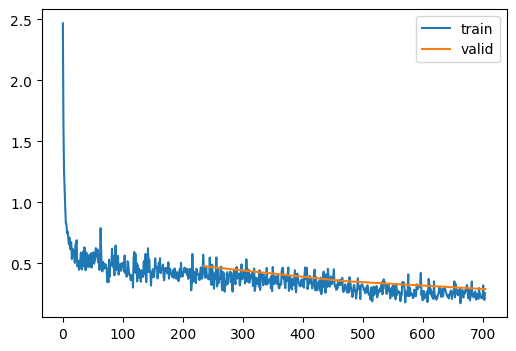

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = 0.1, total_steps = 3*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.1, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(3)

In [ ]:
ocbs = cbs

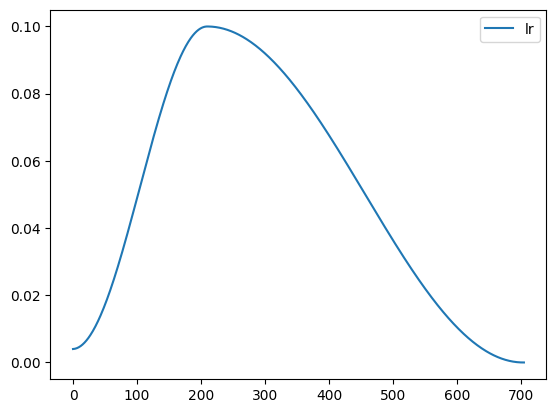

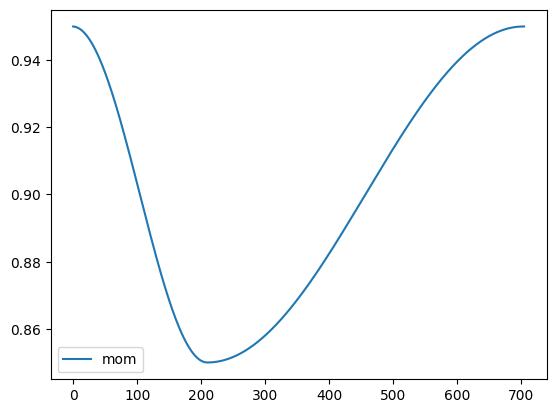

In [ ]:
ocbs[-1].plot()

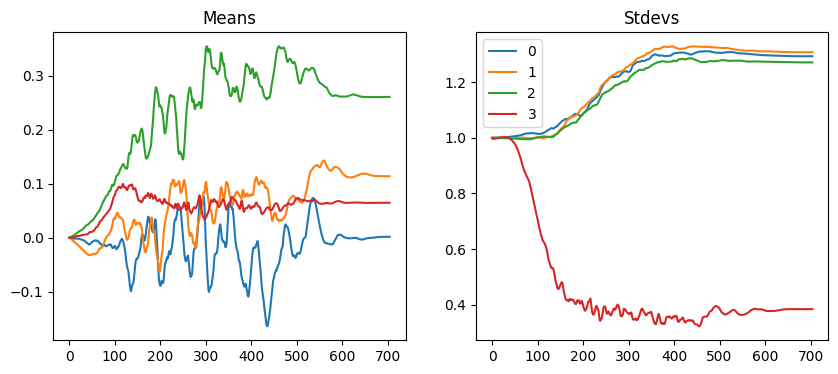

In [ ]:
ocbs[-3].plot_stats()

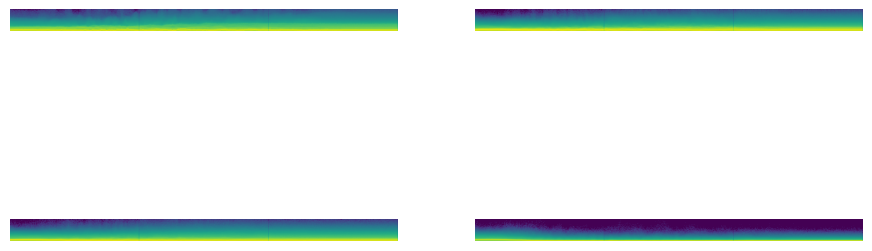

In [ ]:
ocbs[-3].color_dim()

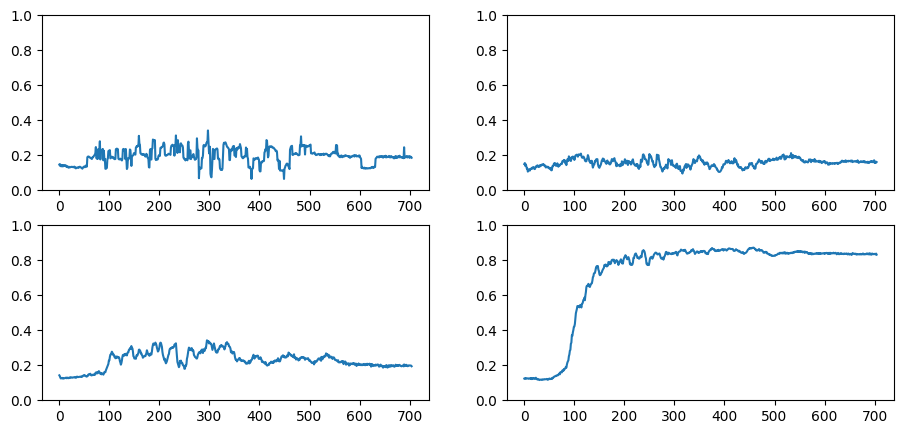

In [ ]:
ocbs[-3].dead_chart()

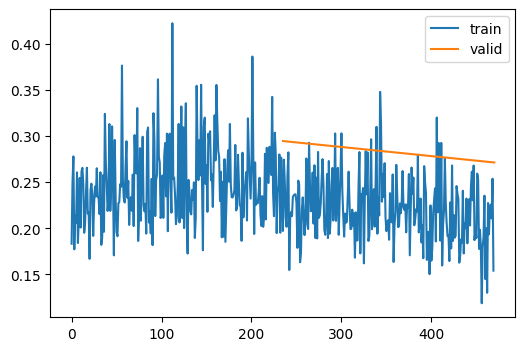

In [ ]:
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = 1e-02, total_steps = 2*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 1e-02, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(2)

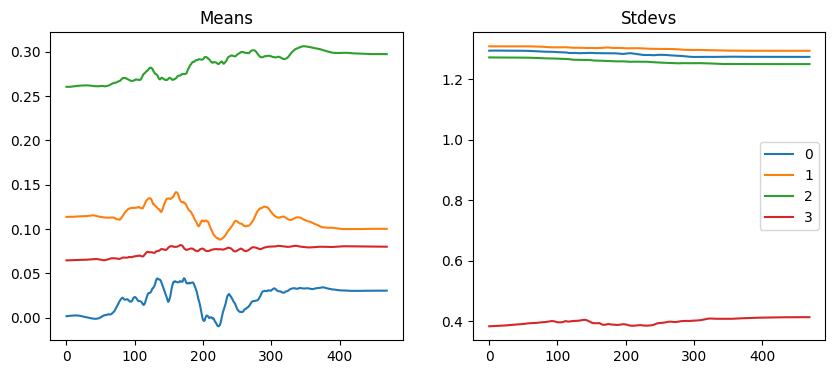

In [ ]:
cbs[-3].plot_stats()

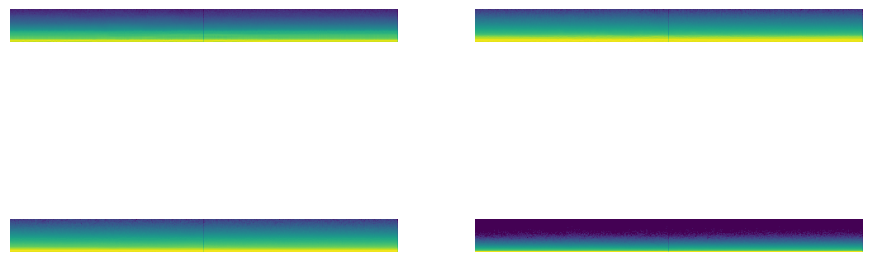

In [ ]:
cbs[-3].color_dim()

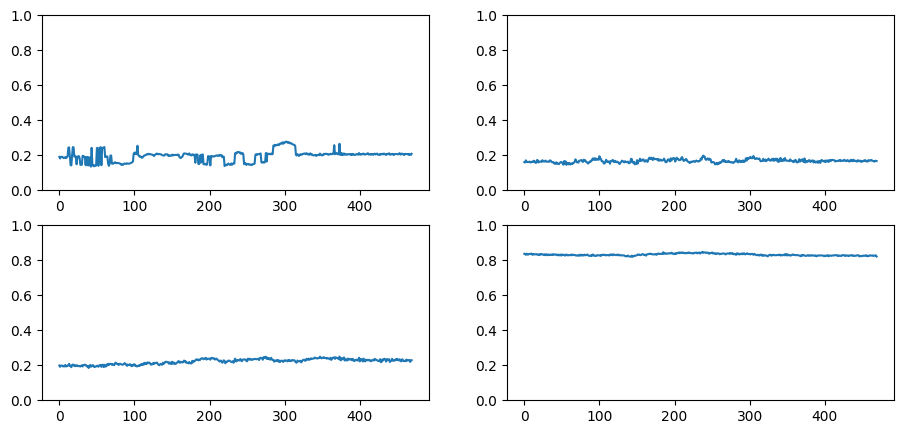

In [ ]:
cbs[-3].dead_chart()

In [ ]:
??learner.fit

In [ ]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128], nc = 10, norm = None, bias = True):
  l1 = conv(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm, bias = True) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  layers = [l1] + [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None, norm = norm), nn.Flatten())

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)

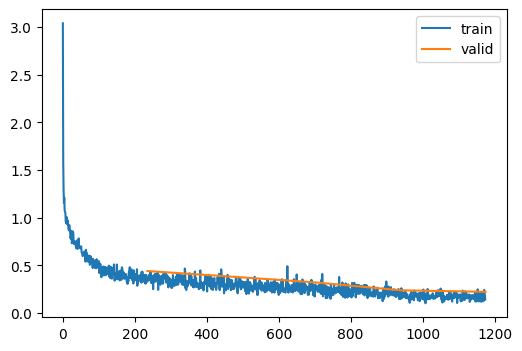

In [ ]:
max_lr, epochs = 5e-02, 5
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

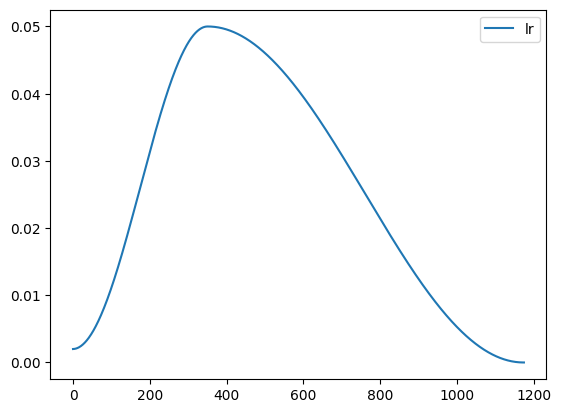

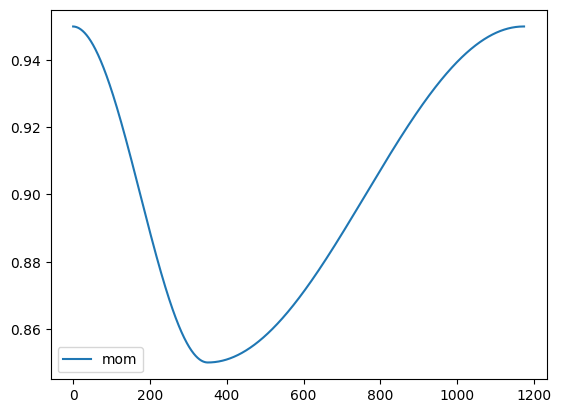

In [ ]:
cbs[-1].plot()

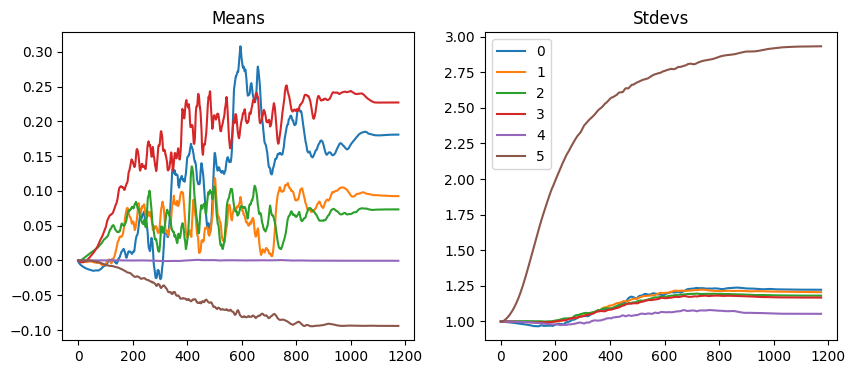

In [ ]:
cbs[-3].plot_stats()

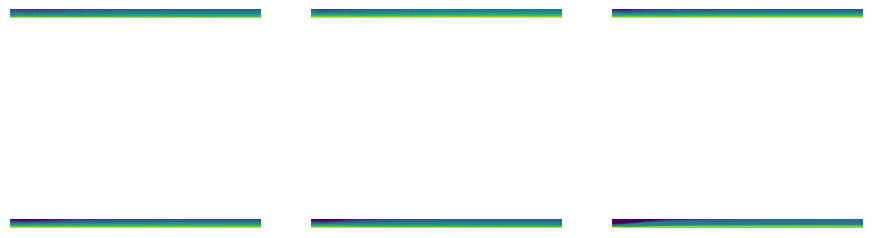

In [ ]:
cbs[-3].color_dim()

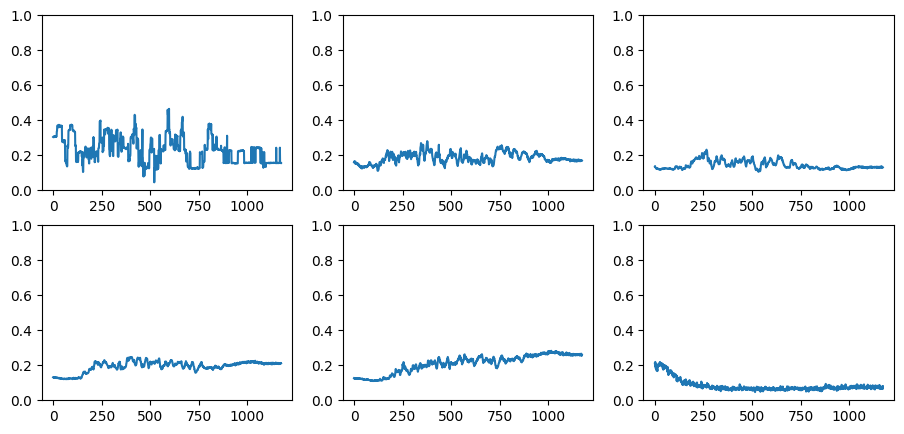

In [ ]:
cbs[-3].dead_chart()

Total Number of elements: 392, number of dead_activations pct: 0.5510203838348389
Total Number of elements: 8, number of dead_activations pct: 0.25
Total Number of elements: 8, number of dead_activations pct: 0.0
Total Number of elements: 8, number of dead_activations pct: 0.125
Total Number of elements: 1152, number of dead_activations pct: 0.5642361044883728
Total Number of elements: 16, number of dead_activations pct: 0.0
Total Number of elements: 16, number of dead_activations pct: 0.25
Total Number of elements: 4608, number of dead_activations pct: 0.54296875
Total Number of elements: 32, number of dead_activations pct: 0.0
Total Number of elements: 32, number of dead_activations pct: 0.28125
Total Number of elements: 18432, number of dead_activations pct: 0.5251736044883728
Total Number of elements: 64, number of dead_activations pct: 0.0
Total Number of elements: 64, number of dead_activations pct: 0.1875
Total Number of elements: 73728, number of dead_activations pct: 0.5657009

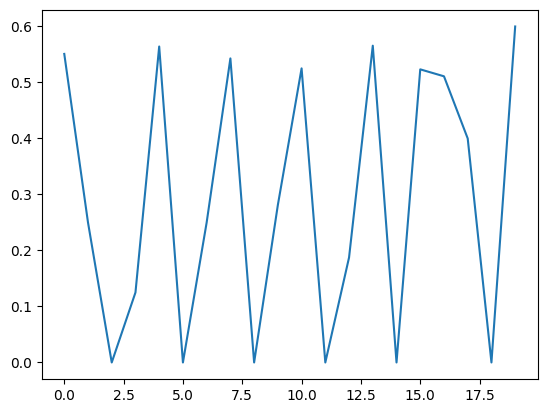

In [ ]:
dead_pcts = [dead_pct(p) for p in list(model.parameters())]
plt.plot(dead_pcts)

In [ ]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = conv(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm, bias = True) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

In [ ]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): GeneralRelu()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): 

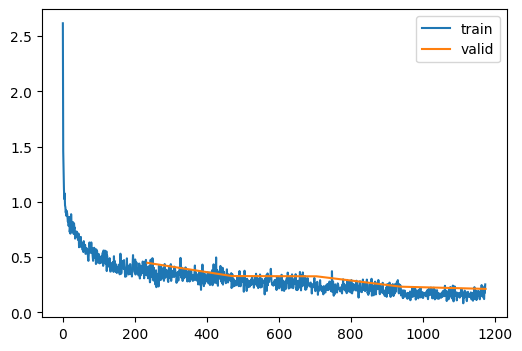

In [ ]:
max_lr, epochs = 5e-02, 5
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

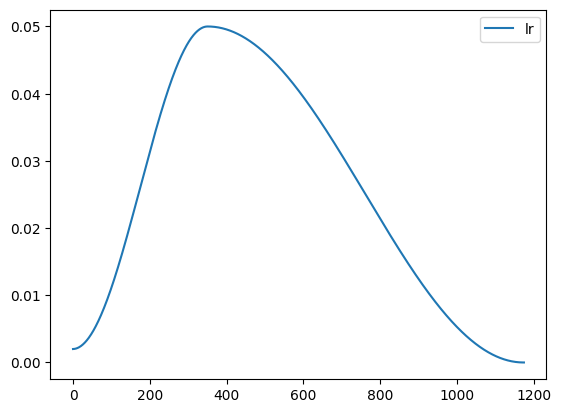

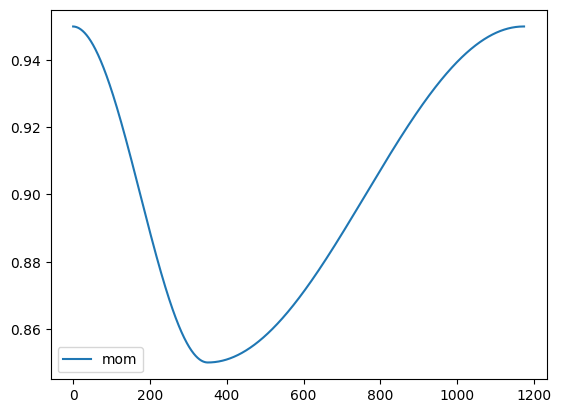

In [ ]:
cbs[-1].plot()

# Lets go with ResNets now!

In [ ]:
'''
ResBlocks

The fundamental

1. for every layer do very little transformation(for activities like reducing the grid size or something like that - hence the id conv if no transformation do nothing)
   with existing activation and preserve it

2. Now create a playground environment kind of layer where we want to transform as much as possible - add as many layers as possible - what ever.


'''

'\nResBlocks\n\nThe fundamental\n\n1. for every layer do very little transformation(for activities like reducing the grid size or something like that - hence the id conv if no transformation do nothing)\n   with existing activation and preserve it\n\n2. Now create a playground environment kind of layer where we want to transform as much as possible - add as many layers as possible - what ever. \n\n\n'

In [6]:
class ResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.pf[-1].weight, 0.)

  def play(self, x):
    inter = self.convs(x)
    return  inter + self.pf(inter)

  def forward(self, x): return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

In [7]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [ResBlock(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

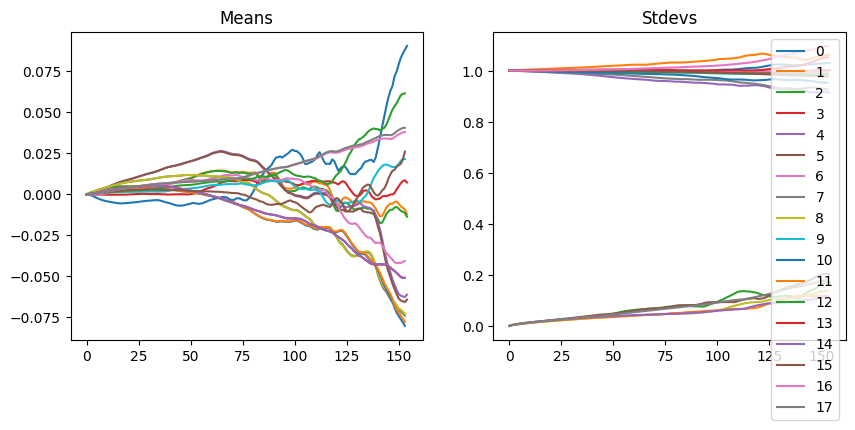

In [17]:
cbs[-3].plot_stats()

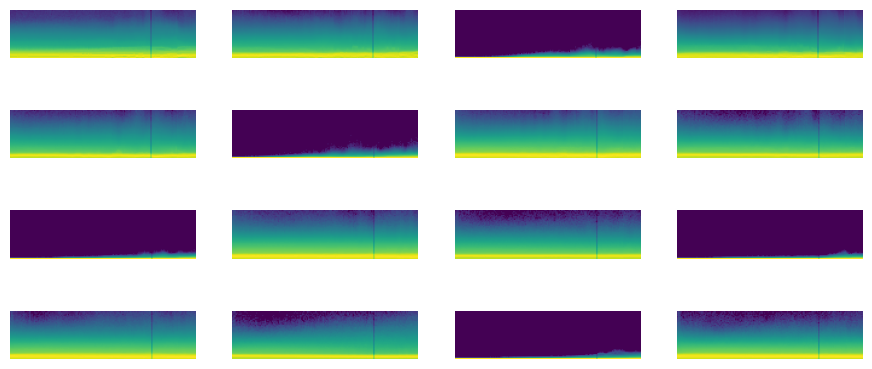

In [18]:
cbs[-3].color_dim()

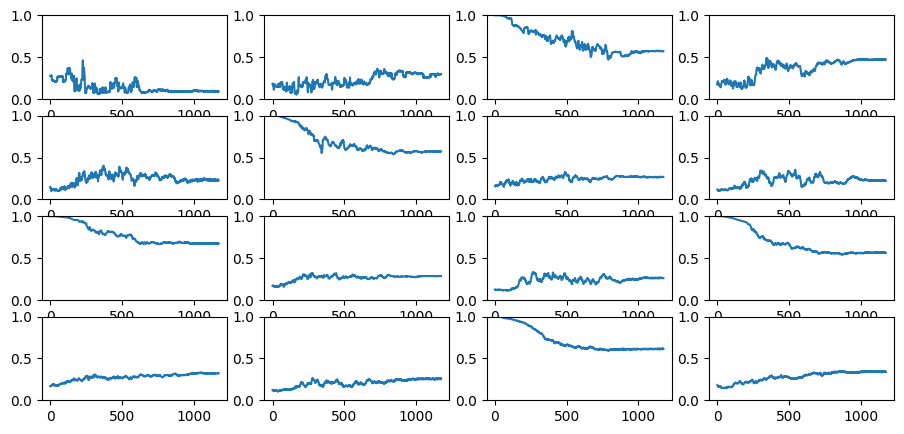

In [ ]:
cbs[-3].dead_chart()

In [19]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [ResBlock(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

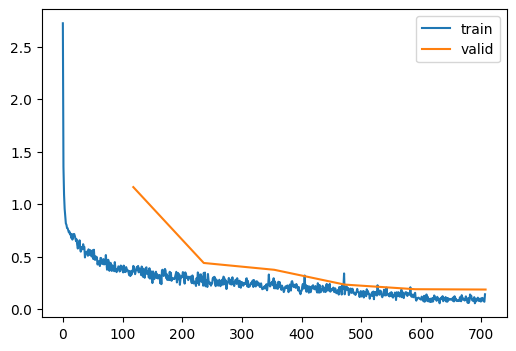

In [8]:
# Going little wider and deeper - 0
model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
max_lr, epochs = 5e-02, 10
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [9]:
learner.summary()

Tot params: 8051220; MFLOPS: 31.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 1, 28, 28)|(512, 16, 28, 28)|4928|3.7|
|ResBlock|(512, 16, 28, 28)|(512, 32, 14, 14)|23872|4.6|
|ResBlock|(512, 32, 14, 14)|(512, 64, 7, 7)|94848|4.6|
|ResBlock|(512, 64, 7, 7)|(512, 128, 4, 4)|378112|6.0|
|ResBlock|(512, 128, 4, 4)|(512, 256, 2, 2)|1509888|6.0|
|ResBlock|(512, 256, 2, 2)|(512, 512, 1, 1)|6034432|6.0|
|Flatten|(512, 512, 1, 1)|(512, 512)|0|0.0|
|Linear|(512, 512)|(512, 10)|5120|0.0|
|BatchNorm1d|(512, 10)|(512, 10)|20|0.0|


In [10]:
class AveragePool(nn.Module):
  def forward(self, x): return x.mean((-1, -2))

In [11]:
def get_model_v2(act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [ResBlock(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

In [12]:
model = get_model_v2(act = act, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = nn.BatchNorm2d, bias = True)

In [13]:
max_lr, epochs = 5e-02, 5
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)

In [14]:
learner.summary()

Tot params: 2014228; MFLOPS: 25.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 1, 28, 28)|(512, 16, 28, 28)|4928|3.7|
|ResBlock|(512, 16, 28, 28)|(512, 32, 14, 14)|23872|4.6|
|ResBlock|(512, 32, 14, 14)|(512, 64, 7, 7)|94848|4.6|
|ResBlock|(512, 64, 7, 7)|(512, 128, 4, 4)|378112|6.0|
|ResBlock|(512, 128, 4, 4)|(512, 256, 2, 2)|1509888|6.0|
|AveragePool|(512, 256, 2, 2)|(512, 256)|0|0.0|
|Linear|(512, 256)|(512, 10)|2560|0.0|
|BatchNorm1d|(512, 10)|(512, 10)|20|0.0|


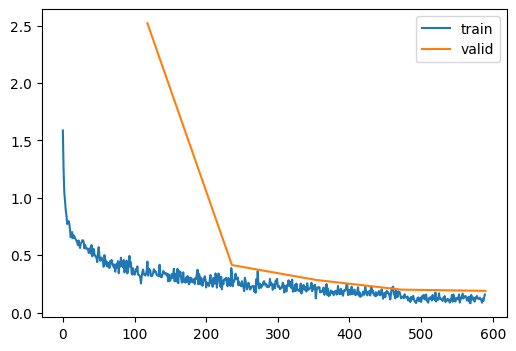

In [15]:
learner.fit(epochs)

In [16]:
class SimpleResBlock(nn.Module):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act):
    super().__init__()
    fc.store_attr()
    self.create_id()
    self.create_playground()
    self.act_fn = act()

  def create_id(self):
    self.id_conv = fc.noop if self.ni == self.nf and self.stride == 1 else conv(self.ni, self.nf, stride = 1, ks = 1, norm = None, act = None)
    self.avg_pool = fc.noop if self.stride == 1 else nn.AvgPool2d(2, ceil_mode = True)

  def conserve(self, x): return self.id_conv(self.avg_pool(x))

  def create_playground(self):
    layers = [
        conv(self.ni, self.nf, stride = 1, norm = self.norm, act = self.act),
        conv(self.nf, self.nf, stride = self.stride, norm = self.norm, act = self.act),
    ]
    self.convs = nn.Sequential(*layers)
    # self.pf = conv(self.nf, self.nf, stride = 1, act = self.act, norm = self.norm)
    if self.norm:
      nn.init.constant_(self.convs[-1][-1].weight, 0.)

  def play(self, x):
    return  self.convs(x)

  def forward(self, x):
    return self.act_fn(self.conserve(x) + self.play(x))

  def __name__(self):
    return 'ResBlock'

In [17]:
def get_model_v3(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

In [18]:
model = get_model_v3(block = SimpleResBlock, act = act, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = nn.BatchNorm2d, bias = True)

In [19]:
max_lr, epochs = 5e-02, 6
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)

In [20]:
learner.summary()

Tot params: 1227076; MFLOPS: 14.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|SimpleResBlock|(512, 1, 28, 28)|(512, 16, 28, 28)|2576|1.9|
|SimpleResBlock|(512, 16, 28, 28)|(512, 32, 14, 14)|14560|2.8|
|SimpleResBlock|(512, 32, 14, 14)|(512, 64, 7, 7)|57792|2.8|
|SimpleResBlock|(512, 64, 7, 7)|(512, 128, 4, 4)|230272|3.7|
|SimpleResBlock|(512, 128, 4, 4)|(512, 256, 2, 2)|919296|3.7|
|AveragePool|(512, 256, 2, 2)|(512, 256)|0|0.0|
|Linear|(512, 256)|(512, 10)|2560|0.0|
|BatchNorm1d|(512, 10)|(512, 10)|20|0.0|


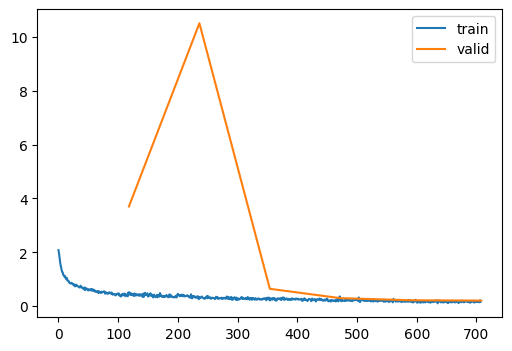

In [21]:
learner.fit(epochs)

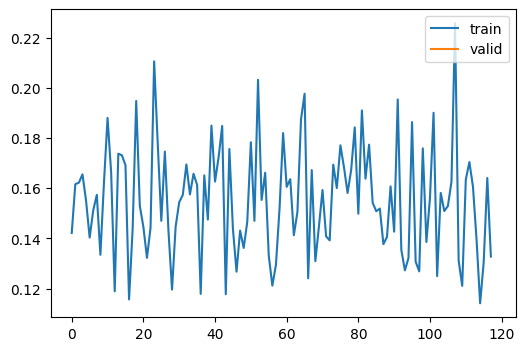

In [23]:
max_lr, epochs = 1e-04, 1
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.CosineAnnealingLR, T_max = len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

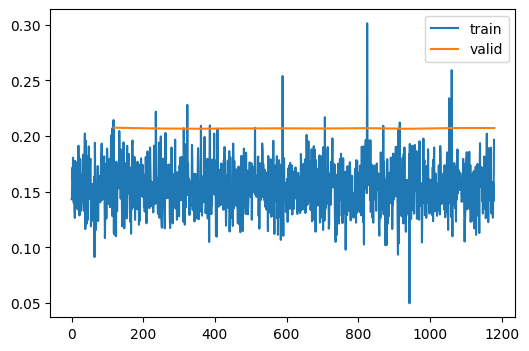

In [24]:
max_lr, epochs = 1e-05, 10
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.CosineAnnealingLR, T_max = epochs * len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# 10 Epoch Exp

In [28]:
# Going little wider and deeper - 0
model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)

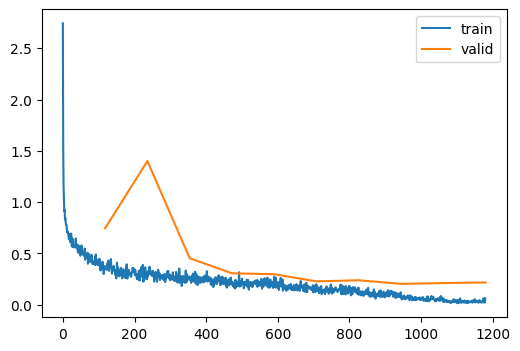

In [30]:
max_lr, epochs = 5e-02, 10
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

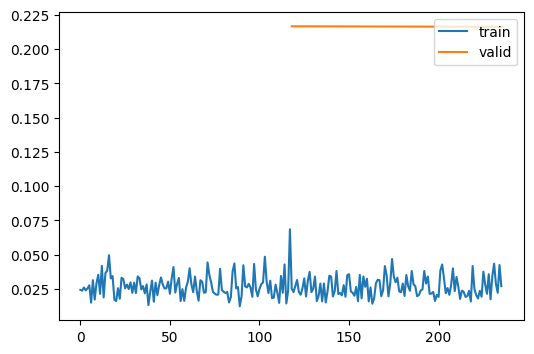

In [31]:
max_lr, epochs = 1e-05, 2
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# Data Augmentation

In [27]:
# Regularization

In [73]:
from torchvision import transforms
from torchvision.transforms import v2

In [ ]:
dir(transforms)

In [34]:
from torchvision.transforms import v2

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [35]:
x, y = next(iter(dls.train))

In [36]:
x.shape, y.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [37]:
ax = x[:16]

In [39]:
ax.device

device(type='cpu')

In [40]:
ax.shape

torch.Size([16, 1, 28, 28])

In [45]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

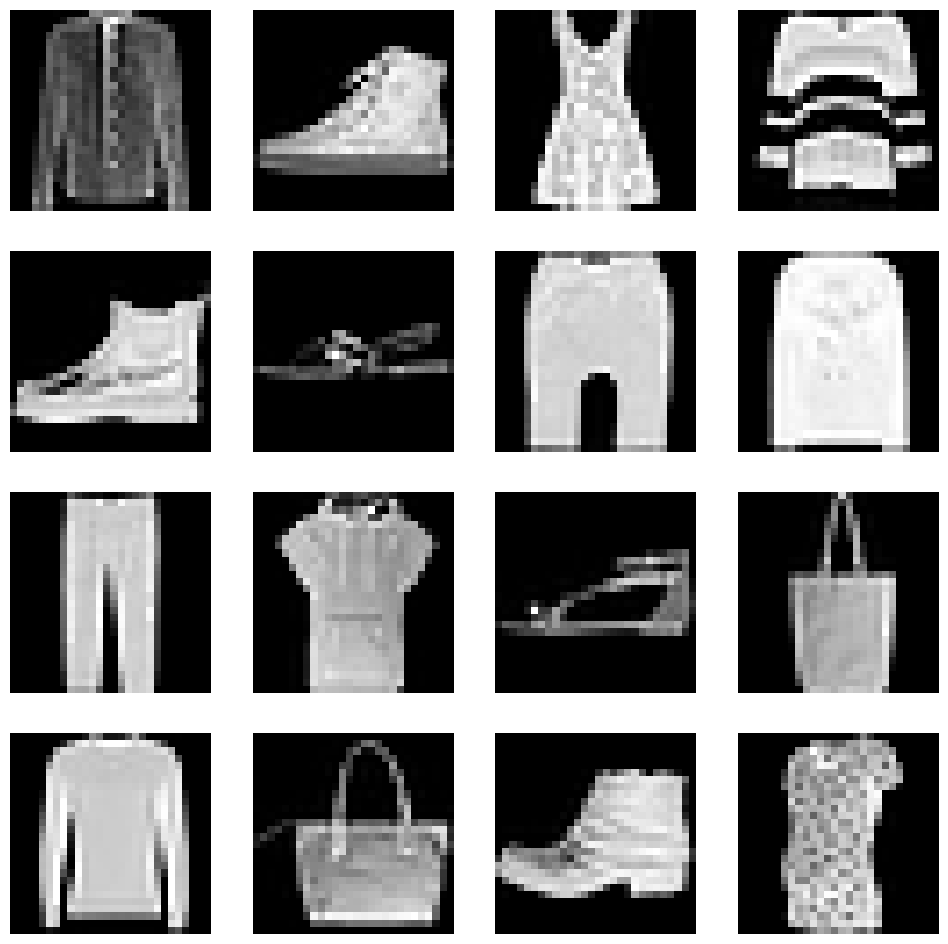

In [46]:
show_images(ax)

In [47]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=0.5)

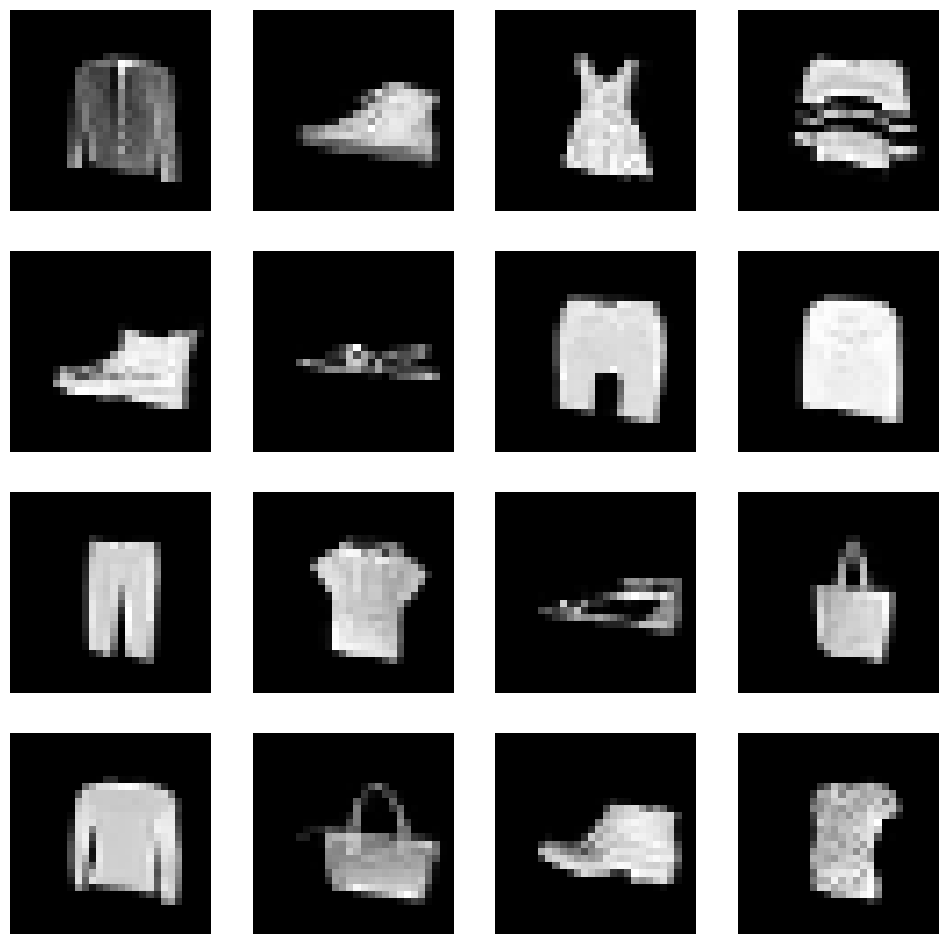

In [55]:
tax = perspective_transformer(ax)
show_images(tax)

In [50]:
ax.mean(), ax.std(), tax.mean(), tax.std()

(tensor(0.3155), tensor(0.3759), tensor(0.1428), tensor(0.2892))

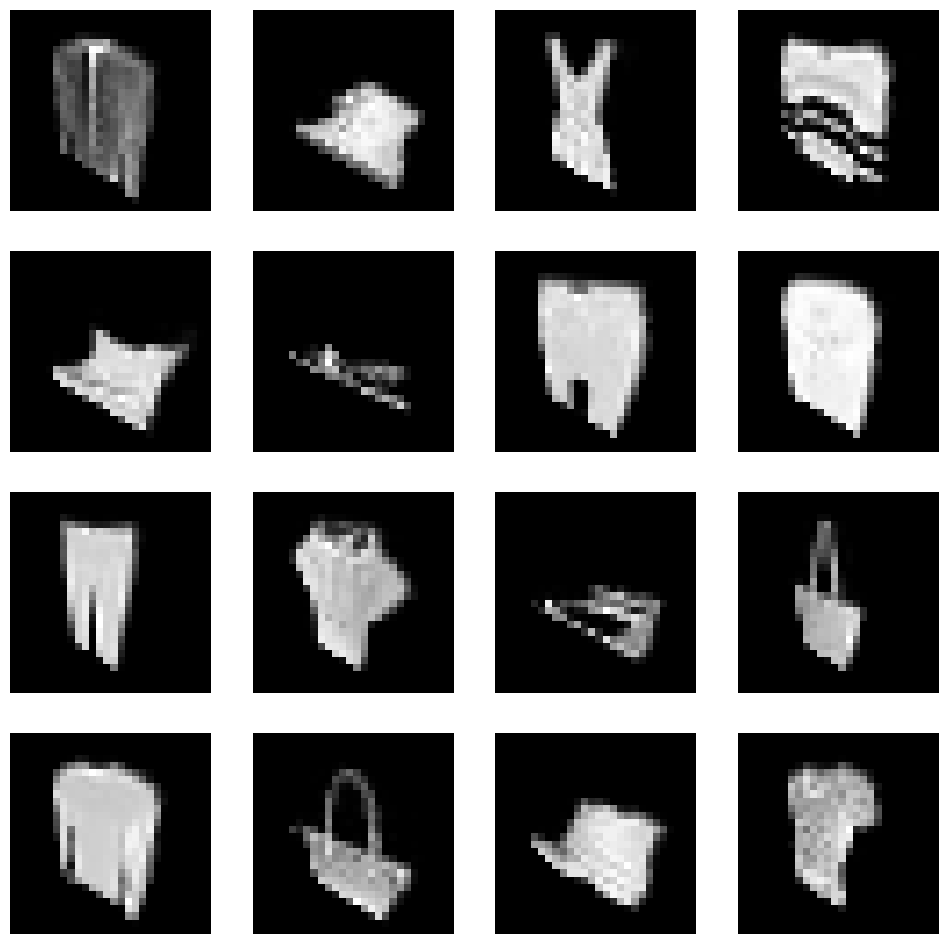

In [67]:
rotater = v2.RandomRotation(degrees=(0, 180))

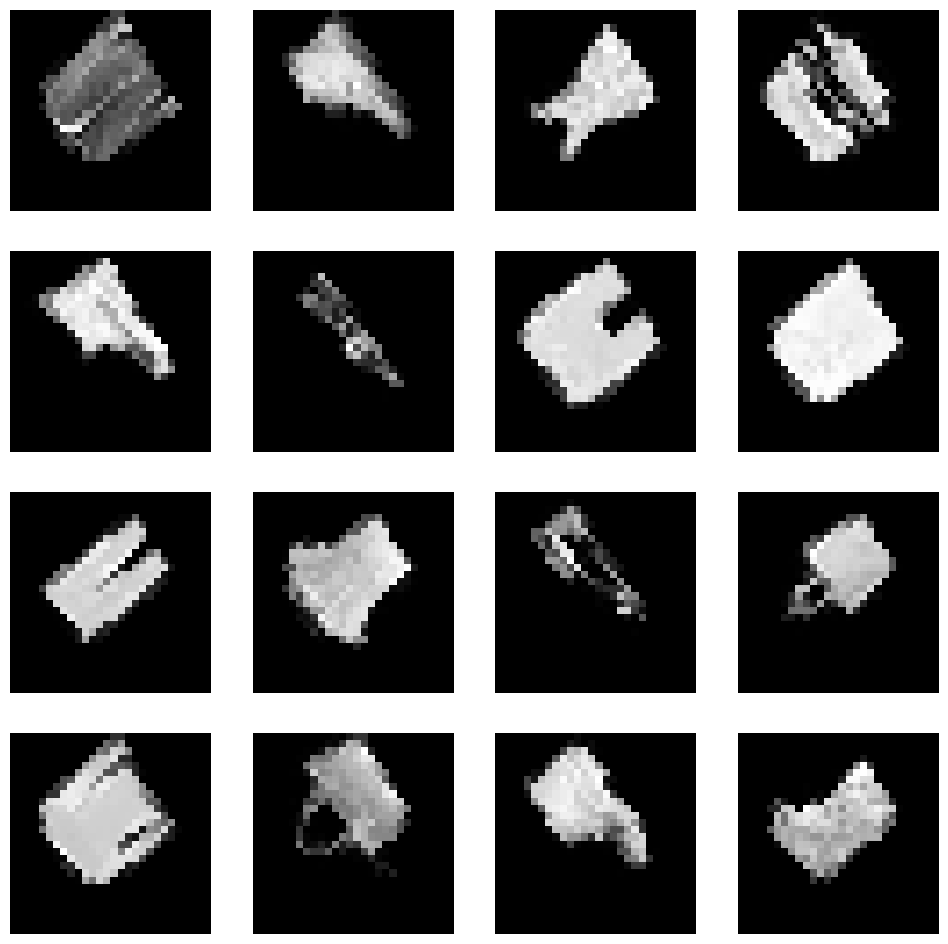

In [66]:
show_images(rotater(tax))

In [62]:
blurrer = v2.GaussianBlur(kernel_size = (5, 9), sigma= (0.1, 1.))

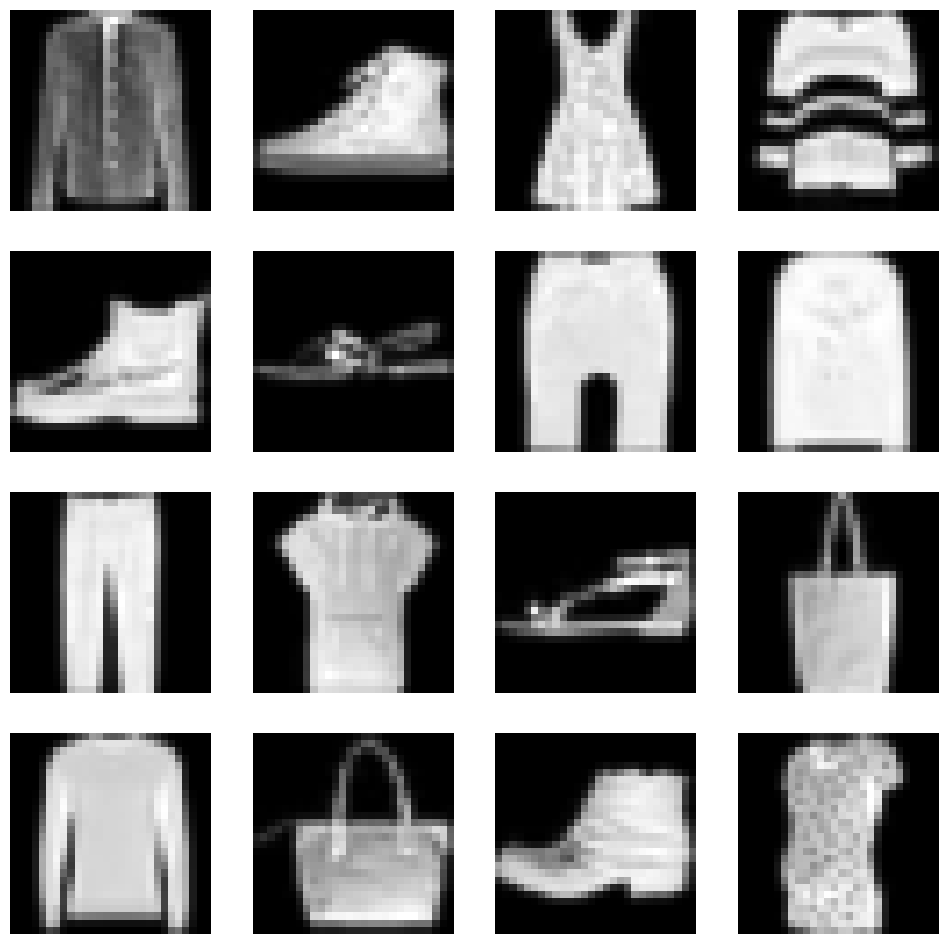

In [64]:
show_images(blurrer(ax))

In [9]:
tfms = transforms.RandomApply(torch.nn.ModuleList([
  v2.RandomPerspective(distortion_scale=0.6, p = 1.0),
  v2.RandomRotation(degrees=(0, 360)),
]), p=0.5)

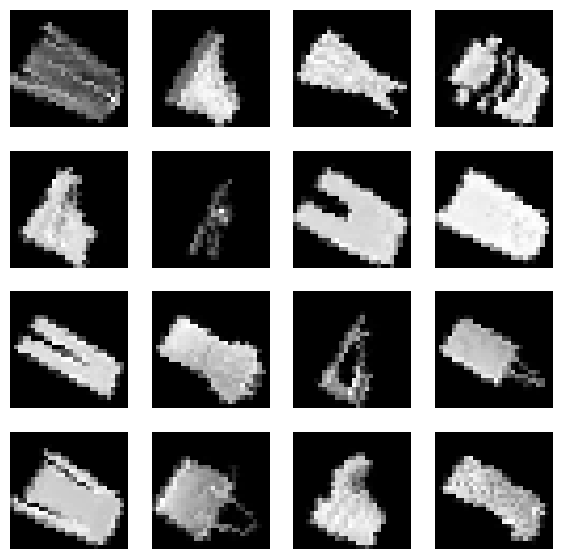

In [137]:
show_images(tfms(ax), figsize=(7, 7))

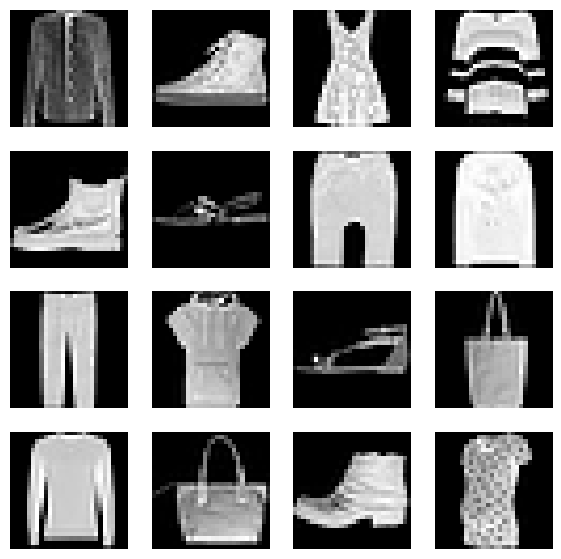

In [123]:
show_images(ax, figsize = (7, 7))

In [144]:
class DataAugCB(Callback):
  def __init__(self, tfms = [v2.RandomPerspective(distortion_scale=0.6, p = 1.0), v2.RandomRotation(degrees=(0, 360))]):
    self.tfms = transforms.RandomApply(torch.nn.ModuleList(tfms), p=0.5)

  def before_batch(self, learn):
    if learn.training: learn.batch = (self.tfms(learn.batch[0]), learn.batch[1])

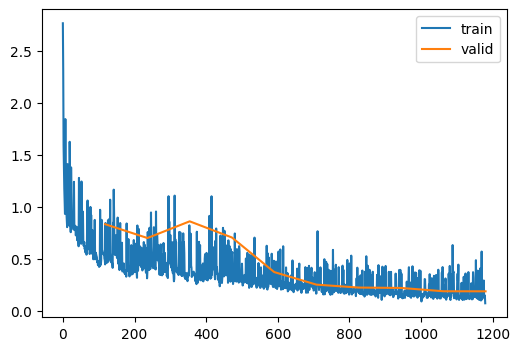

In [146]:
# Going little wider and deeper - 0
model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
max_lr, epochs = 5e-02, 10
cbs = get_callbacks(nn.BatchNorm2d) + [DataAugCB(tfms = [v2.RandomPerspective(distortion_scale=0.6, p = 0.5)]), BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

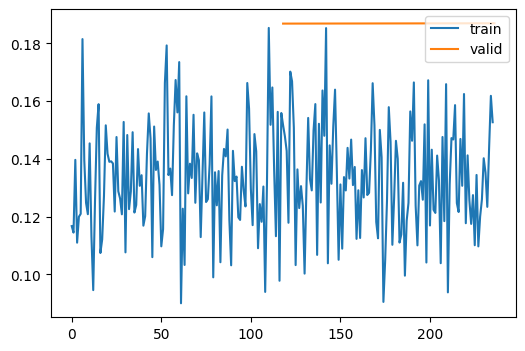

In [147]:

# model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
max_lr, epochs = 1e-05, 2
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = max_lr, total_steps = epochs*len(dls.train))), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# Learning Rate Scheduler Implementation!

In [12]:
model = get_model_v3()

In [16]:
opt = optim.AdamW(model.parameters(), lr=0.02)

In [20]:
lrs = lr_scheduler.CosineAnnealingLR(opt, T_max= 100)

In [18]:
opt.param_groups[0]['lr']

0.02

In [21]:
lr = []
for i in range(100):
  lr.append(opt.param_groups[0]['lr'])
  opt.step()
  lrs.step()

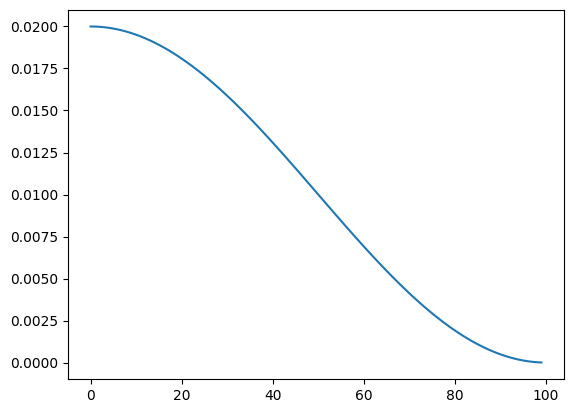

In [22]:
plt.plot(lr)

In [98]:
class LRScheduler:
  def __init__(self):
    self.batch_count = 0

  def step(self):
    raise NotImplementedError()

In [108]:
class CosineAnnelingLRS(LRScheduler):
  def __init__(self, opt, T_max = None, max_lr = None):
    super().__init__()
    fc.store_attr()
    self.setup()
    self.update_max_lr()

  def update_max_lr(self):
    if not self.max_lr: self.max_lr = self.opt.param_groups[0]['lr']

  def setup(self):
    # Create a evenly distributed point list from 0 to pi/2
    # 1. create a cosine distribution from 0 to pi/2 - [1, -1]
    # 2. add 1.0  it  - [2, 0]
    # 3. half it - [1, 0]to
    space = torch.linspace(0., math.pi, steps = self.T_max)
    self.dist = iter((torch.cos(space) + 1.)/2)

  def get_lr(self):
    return next(self.dist)*self.max_lr

  def step(self):
    lr = float(self.get_lr())
    for i in self.opt.param_groups:
      i['lr'] = lr
      self.batch_count += 1

  def reset(self):
    self.batch_count = 0
    self.setup()

In [100]:
model = get_model_v3()
opt = optim.AdamW(model.parameters(), lr = 1e-02)
lrs = CosineAnnelingLRS(opt, T_max = 400)

In [101]:
lr = []
for i in range(400):
  lr.append(opt.param_groups[0]['lr'])
  opt.step()
  lrs.step()

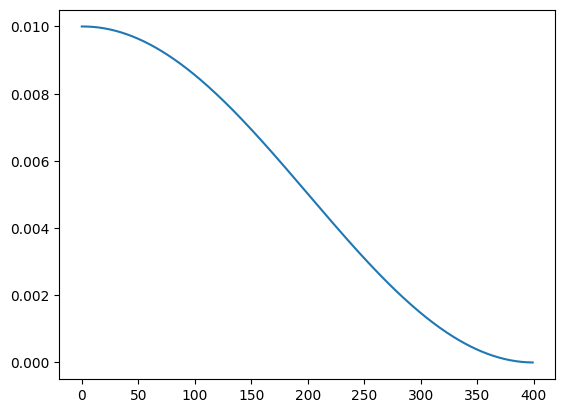

In [102]:
plt.plot(lr)

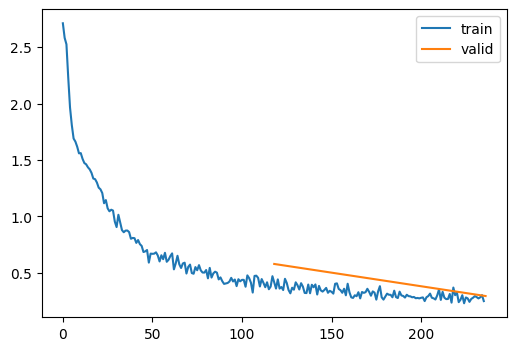

In [109]:
# Going little wider and deeper - 0
model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
max_lr, epochs = 4e-02, 2
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(CosineAnnelingLRS, max_lr = max_lr, T_max = epochs*len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [110]:
opt

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0
    maximize: False
    weight_decay: 0.01
)

In [141]:
class OneCycleLRS(LRScheduler):
  def __init__(self, opt, total_steps = None, num_epochs = None, steps_per_epoch = None, lr_min = None, lr_max = None, b_min = None, b_max = None, tip_off = 0.2):
    super().__init__()
    self.opt = opt
    self.tip_off = tip_off
    self.total_steps = self.calculate_steps(total_steps, num_epochs, steps_per_epoch)
    self.lr_range = self.get_lr_range(lr_min, lr_max)
    self.beta_range = self.get_beta_range(b_min, b_max)
    self.setup()

  def calculate_steps(self, total_steps, num_epochs, steps_per_epoch):
    if total_steps: return total_steps
    elif steps_per_epoch and num_epochs: return steps_per_epoch*num_epochs
    else: raise ValueError("Couldn't determine total number of steps")

  def get_lr_range(self, lr_min, lr_max):
    if not lr_min: lr_min = 1e-07
    if not lr_max: lr_max = self.opt.param_groups[0]['lr']
    return lr_min, lr_max

  def get_beta_range(self, b_min, b_max):
    if not b_min: b_min = self.opt.param_groups[0]['betas'][0]
    if not b_max: b_max = 0.96 if b_min <= self.opt.param_groups[0]['betas'][0] else 0.99
    return b_min, b_max

  def setup(self):
    # step - 1 - create the first part of it - increase
    p1_step_count = int(self.total_steps*self.tip_off)
    p1_dist = (torch.cos(torch.linspace(math.pi, 2*math.pi, steps = p1_step_count)) + 1)/2

    # step - 2 - create the next part of it - decrease
    p2_step_count = self.total_steps - p1_step_count
    p2_dist = (torch.cos(torch.linspace(0, math.pi, steps = p2_step_count)) + 1)/2

    self.dist = iter(torch.cat((p1_dist, p2_dist), dim = 0))
    self.opt.param_groups[0]['lr'] = self.lr_range[0]
    self.opt.param_groups[0]['betas'] = (self.beta_range[1], self.opt.param_groups[0]['betas'][1])

  def step(self):
    lr_coef = float(next(self.dist))
    beta_coef = 1 - lr_coef
    self.opt.param_groups[0]['lr'] = self.lr_range[0] + (self.lr_range[1] - self.lr_range[0])*lr_coef
    self.opt.param_groups[0]['betas'] = ((self.beta_range[0] + (self.beta_range[1] - self.beta_range[0])*beta_coef), self.opt.param_groups[0]['betas'][1])
    self.batch_count += 1

In [142]:
model = get_model_v3()
opt = optim.AdamW(model.parameters(), lr = 4e-02)
lrs = OneCycleLRS(opt, total_steps = 100, tip_off = 0.22)

In [143]:
lr, betas = [], []
for i in range(100):
  lr.append(opt.param_groups[0]['lr'])
  betas.append(opt.param_groups[0]['betas'][0])
  opt.step()
  lrs.step()

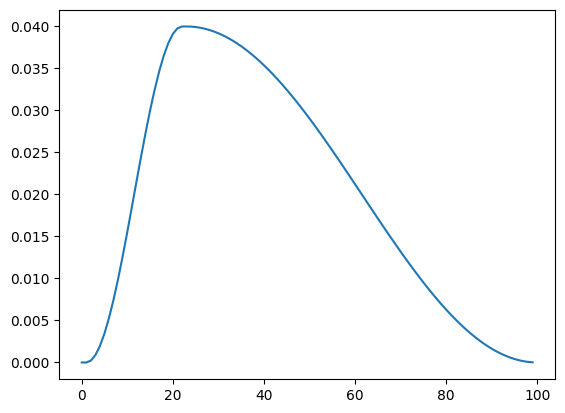

In [144]:
plt.plot(lr)

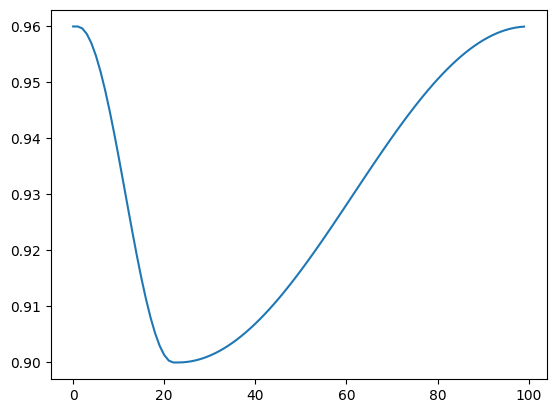

In [145]:
plt.plot(betas)

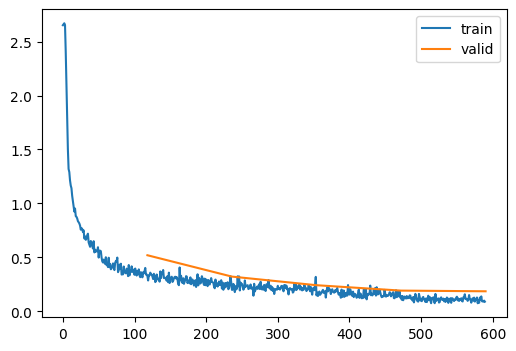

In [146]:
# Going little wider and deeper - 0
model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
lr_max, epochs = 4e-02, 5
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = max_lr, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# Dropout and Dropout2D!

In [7]:
class Dropout(nn.Module):
  def __init__(self, p = 0.2):
    super().__init__()
    self.p = p

  def forward(self, x):
    if not self.training: return x
    mask = torch.bernoulli(torch.full(x.shape, (1 - self.p))).to(x.device)
    return x*mask*(1/(1 - self.p))

In [8]:
class Dropout2d(Dropout):

  def forward(self, x):
    if not self.training: return x
    dist = torch.bernoulli(torch.full(x.shape[1:-2], (1 - p))).to(x.device)
    scaling_factor = float(dist.sum()/x.shape[1])
    out = dist[None, :, None, None] * x
    return out*(1/scaling_factor)

In [77]:
a, p = torch.randn(4, 16, 14, 14), 0.2

In [79]:
a, p = torch.randn(4, 5, 14, 14), 0.2
print(a.sum(),)
d = Dropout2d(p)
out = d(a)
out.sum()

tensor(-140.9364)


tensor(-148.3582)

In [71]:
def get_model_v4(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm) # 8*28*28
  # l2 = conv(nfs[1], nfs[2], norm = norm, bias = True) # 16*14*14
  # l3 = conv(nfs[2], nfs[3], norm = norm, bias = True) # 32*7*7
  # l4 = conv(nfs[3], nfs[4], norm = norm, bias = True) # 64*4*4
  # l5 = conv(nfs[4], nfs[5], norm = norm, bias = True) # 128*2*2
  # l6 = conv(nfs[5], nfs[6], norm = norm, bias = True) # 256*1*1
  layers = [l1, Dropout(p)] + [block(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, Dropout(p), AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

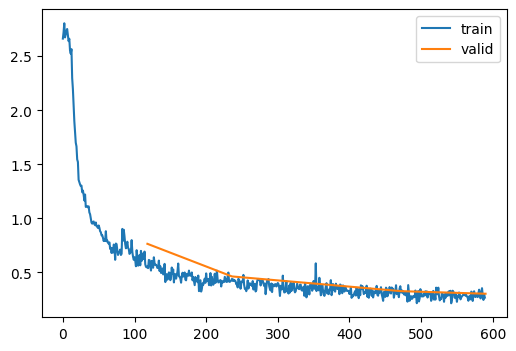

In [80]:
model = get_model_v4()
# Going little wider and deeper - 0
# model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
lr_max, epochs = 4e-02, 5
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

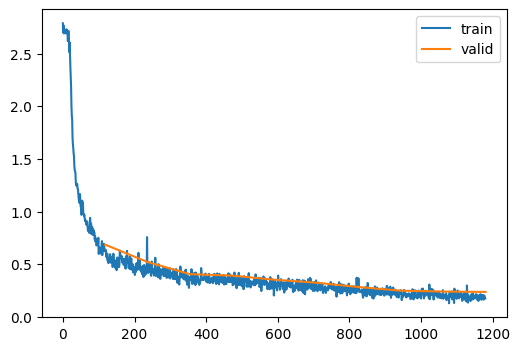

In [81]:
model = get_model_v4()
# Going little wider and deeper - 0
# model = get_model(act = act, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = nn.BatchNorm2d, bias = True)
lr_max, epochs = 4e-02, 10
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train))), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [36]:
class ResBlockD(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act, p = 0.1):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = Dropout(p)

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

In [11]:
def get_model_v5(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) if i <= len(nfs)//2 else ResBlockD(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

In [12]:
model = get_model_v5()

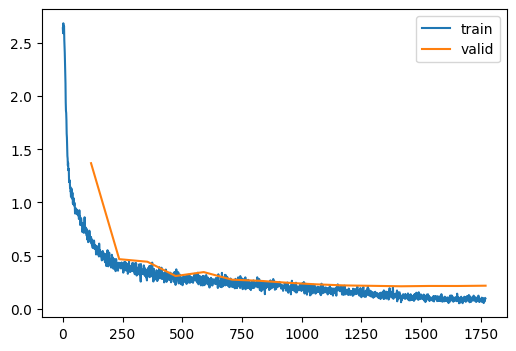

In [15]:
model = get_model_v5()
lr_max, epochs = 1e-02, 15
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.15)), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [81]:
class ResBlockDV2(ResBlock):

  def __init__(self, ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act, p = 0.1, dropout_func = Dropout2d):
    super().__init__(ni, nf, stride = 2, ks = 3, norm = nn.BatchNorm2d, act = act)
    self.drop = dropout_func(p)

  def forward(self, x): return self.drop(super().forward(x))

  def __name__(self):
    return 'ResBlockD'

def get_model_v6(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) if i <= len(nfs)//2 else ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))



In [ ]:
ResBlockDV2

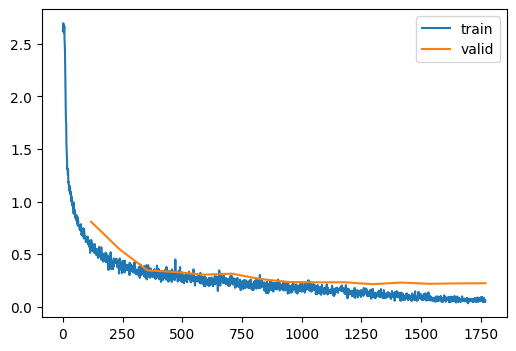

In [19]:
def get_model_v7(block = ResBlock, act = GeneralRelu, nfs = [1, 8, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) if i <= len(nfs)//3 else ResBlockD(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, AveragePool(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

model = get_model_v7(p = 0.15)
lr_max, epochs = 1e-02, 15
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.15)), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

In [37]:
def get_model_v8(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) if i <= len(nfs)//3 else ResBlockD(nfs[i], nfs[i+1], act = act, norm = norm, p = p) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

model = get_model_v8(p = 0.2)

In [ ]:
model = get_model_v8(p = 0.2)
lr_max, epochs = 1e-02, 15
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.15)), RecorderCB(lr = _lr)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)
#93.3

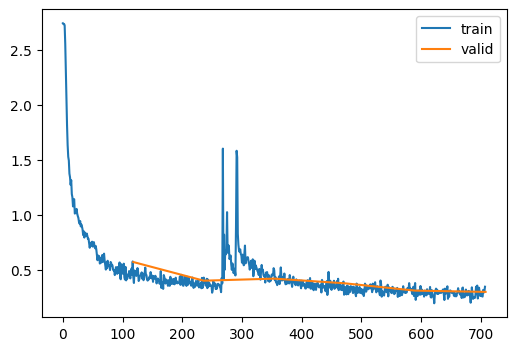

In [40]:
model = get_model_v8(p = 0.3)
lr_max, epochs = 3e-02, 6
cbs = get_callbacks(nn.BatchNorm2d) + [BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.15)), RecorderCB(lr = _lr, mom = _mom)]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# WandB Callback.

In [11]:
import pdb
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [14]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
'''
def _lr(pg): return pg[0]['lr']

def _mom(pg): return pg[0]['betas'][0]

def _rms_prop(pg): return pg[0]['betas'][1]

def _wd(pg): return pg[0]['weight_decay']
'''
class WandBCB(Callback):
  def __init__(self, epochs, metrics = {}, hparams = {}, name = 'Test Run'):
    fc.store_attr()
    run = wandb.init(
        project = name,
        config={
            "epochs": epochs,
        }
    )

  def after_batch(self, learn):
    (x, y), yhat = to_cpu(learn.batch), to_cpu(learn.preds)
    for k, v in self.metrics.items(): v.update(yhat, y)
    log = {k: v.compute() for k, v in self.metrics.items()}
    for k, v in self.hparams.items(): log[k] = v(learn.opt.param_groups)
    log['loss'] = learn.loss.item()
    # print(log)
    wandb.log(log)

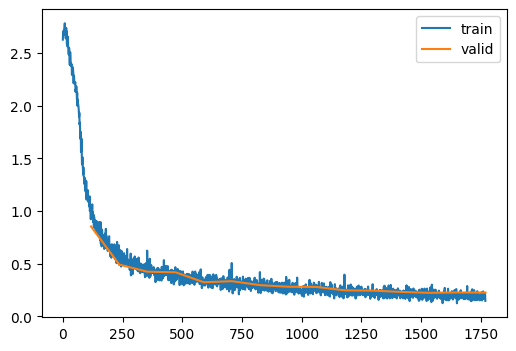

In [22]:
# ResBlockDV2
def get_model_v9(block = ResBlockDV2, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256, 512], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = block(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm, p = p, dropout_func = Dropout2d(p)) for i in range(1, len(nfs)-1)]
  return nn.Sequential(*layers, nn.Flatten(), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

model = get_model_v9(p = 0.5)
lr_max, epochs = 1e-02, 15
cbs = get_callbacks(nn.BatchNorm2d) + [
          WandBCB(name = 'test_run_2 - testing log', epochs = epochs, metrics = {'acc': MulticlassAccuracy()}, hparams = {'lr': _lr, 'p(mom)': _mom, 'rms': _rms_prop}),
          BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.15)),
          RecorderCB(lr = _lr, mom = _mom)
      ]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)
learner.fit(epochs)

# DataAugmentation with Dropout

In [7]:
# ResBlock
def get_model_v10(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [block(nfs[i], nfs[i+1], act = act, norm = norm) for i in range(1, len(nfs[:3]))]
  layers += [ResBlockDV2(nfs[j], nfs[j+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for j in range(len(nfs[:3]), len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

model = get_model_v10(norm = nn.BatchNorm2d, p = 0.25)

In [17]:
lr_max, epochs = 2e-02, 15
cbs = get_callbacks(nn.BatchNorm2d) + [
          DataAugCB([RandCopy()]),
          # WandBCB(name = 'Data Aug with Dropout - Aim 94! - 4', epochs = epochs, metrics = {'acc': MulticlassAccuracy()}, hparams = {'lr': _lr, 'p(mom)': _mom, 'rms_prop': _rms_prop}),
          BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.2)),
          RecorderCB(lr = _lr, mom = _mom),
          # NormTransformCB()
      ]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)

In [13]:
learner.summary()

Tot params: 2014228; MFLOPS: 25.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 1, 28, 28)|(512, 16, 28, 28)|4928|3.7|
|ResBlock|(512, 16, 28, 28)|(512, 32, 14, 14)|23872|4.6|
|ResBlock|(512, 32, 14, 14)|(512, 64, 7, 7)|94848|4.6|
|ResBlockDV2|(512, 64, 7, 7)|(512, 128, 4, 4)|378112|6.0|
|ResBlockDV2|(512, 128, 4, 4)|(512, 256, 2, 2)|1509888|6.0|
|AveragePool|(512, 256, 2, 2)|(512, 256)|0|0.0|
|Dropout|(512, 256)|(512, 256)|0|0.0|
|Linear|(512, 256)|(512, 10)|2560|0.0|
|BatchNorm1d|(512, 10)|(512, 10)|20|0.0|


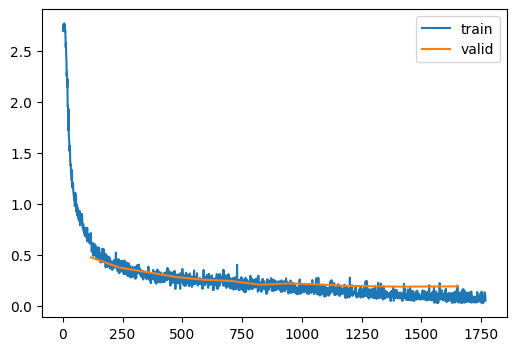

In [ ]:
learner.fit(epochs)

In [ ]:
from google.colab import runtime
runtime.unassign()

# Dropout Scheduler!

In [16]:
class DropoutScheduler(LRScheduler):
  def __init__(self, epochs = 10, min = 0.2, max = 0.5):
    self.drops = iter(torch.linspace(min, max, steps = epochs))

  def step(self):
    return next(self.drops)

In [45]:
class DropoutCB(Callback):
  def __init__(self, drop_sched): fc.store_attr()
  def before_epoch(self, learn):
    if not learn.training: return
    p = self.drop_sched.step()
    for block in learn.model:
      if isinstance(block, ResBlockDV2): block.drop.p = p
      if isinstance(block, (nn.Dropout, nn.Dropout2d)): block.p = p

In [46]:
# ResBlock
def get_model_v11(block = ResBlock, act = GeneralRelu, nfs = [1, 16, 32, 64, 128, 256], nc = 10, norm = None, bias = True, p = 0.2):
  l1 = ResBlock(nfs[0], nfs[1], stride = 1, ks = 7, norm = norm)
  layers = [l1] + [ResBlockDV2(nfs[i], nfs[i+1], act = act, norm = norm, dropout_func= nn.Dropout2d(p)) for i in range(1, len(nfs) - 1)]
  return nn.Sequential(*layers, AveragePool(), nn.Dropout(p), nn.Linear(nfs[-1], nc, bias = False), nn.BatchNorm1d(nc))

model = get_model_v11(norm = nn.BatchNorm2d, p = 0.20)

In [49]:
lr_max, epochs = 2e-02, 50
cbs = get_callbacks(nn.BatchNorm2d) + [
          DataAugCB([RandCopy()]),
          # WandBCB(name = 'Data Aug with Dropout - Aim 94! - 4', epochs = epochs, metrics = {'acc': MulticlassAccuracy()}, hparams = {'lr': _lr, 'p(mom)': _mom, 'rms_prop': _rms_prop}),
          BatchSchedulerCB(partial(OneCycleLRS, lr_max = lr_max, num_epochs = epochs, steps_per_epoch = len(dls.train), tip_off = 0.2)),
          RecorderCB(lr = _lr, mom = _mom),
          NormTransformCB(),
          DropoutCB(drop_sched = DropoutScheduler(epochs = epochs, min = 0.2, max = 0.5))
      ]
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = lr_max, cbs = cbs, opt_func = torch.optim.AdamW)

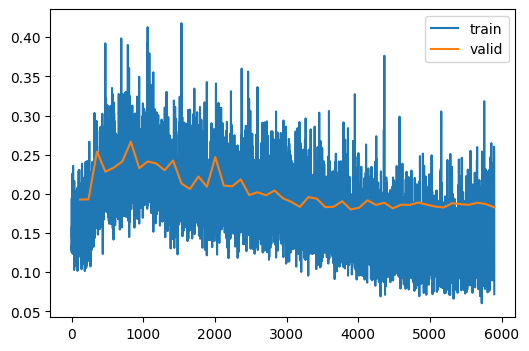

In [ ]:
learner.fit(epochs)

In [ ]:
from google.colab import runtime
runtime.unassign()